In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter, defaultdict
from scipy import stats
import re
from wordcloud import WordCloud
import nltk
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import math
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import warnings
warnings.filterwarnings('ignore')

# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

=== DATASET OVERVIEW ===
Dataset shape: (1502, 6)
Number of observations: 1502
Number of features: 6


=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB
None


=== FIRST 5 ROWS ===
  Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review T

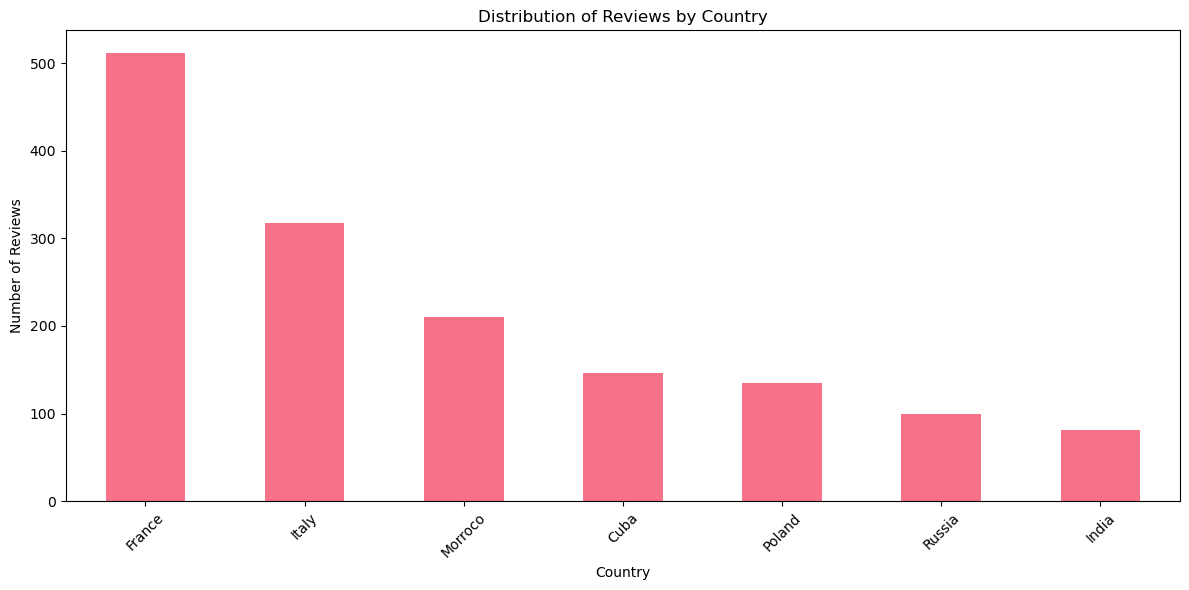



=== TIME RANGE ANALYSIS ===

Analyzing Review Date:
Sample values: ['May 2024 •', 'Feb 2024 •', 'Nov 2023 •', 'Mar 2023 •', 'Nov 2022 •']
Unique values count: 143
Date range: 2010-09-01 00:00:00 to 2024-07-01 00:00:00
Time span: 5052 days (13.8 years)
Years covered: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Number of different months: 139


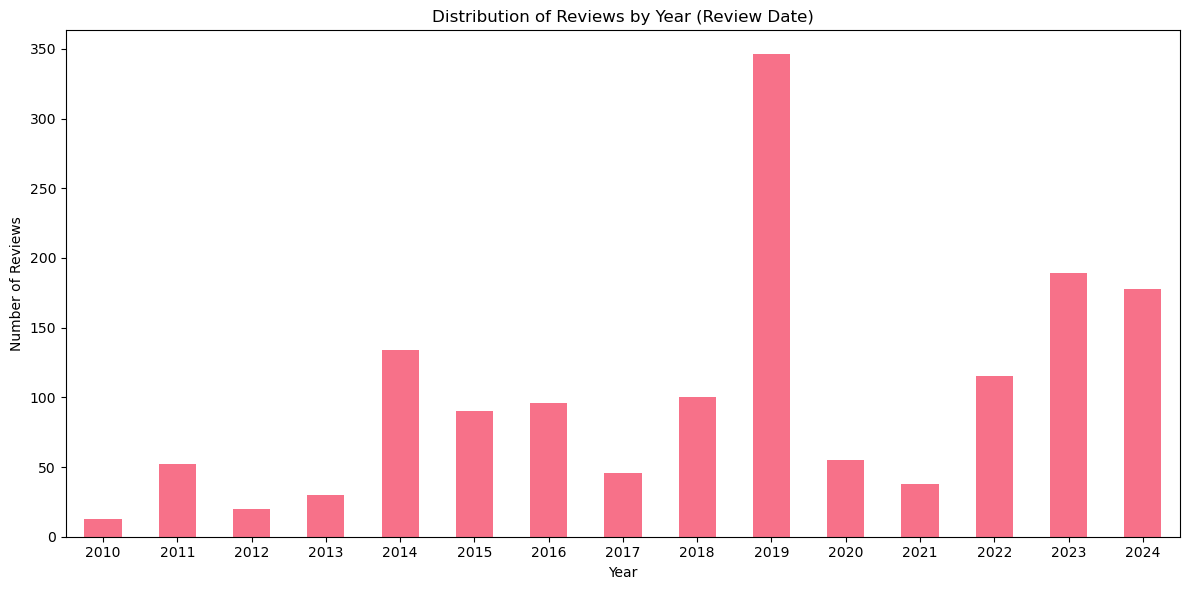

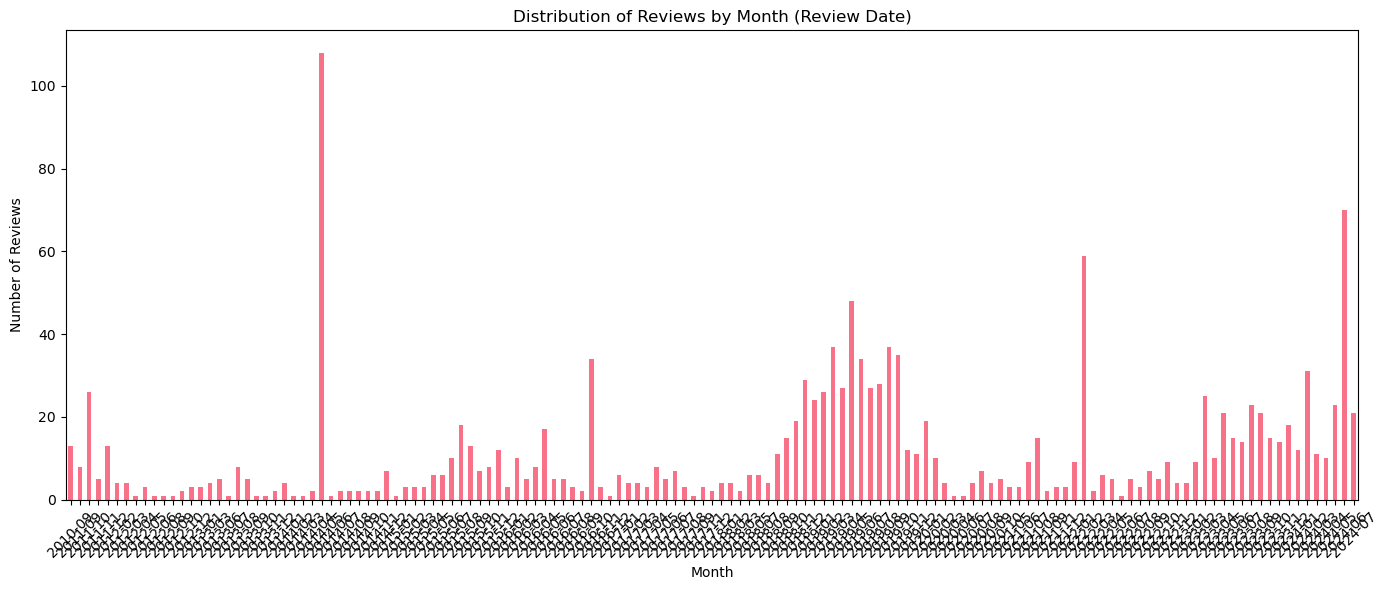



=== RESTAURANT BALANCE ANALYSIS ===

Analyzing Restaurant Name:
Number of unique restaurants: 7
Average reviews per restaurant: 214.57
Median reviews per restaurant: 146.00
Min reviews per restaurant: 81
Max reviews per restaurant: 512

Top 10 restaurants by number of reviews:
Restaurant Name
The Frog at Bercy Village                512
Ad Hoc Ristorante (Piazza del Popolo)    318
The LOFT                                 210
Old Square (Plaza Vieja)                 146
Stara Kamienica                          135
Pelmenya                                 100
Mosaic                                    81
Name: count, dtype: int64

Coefficient of variation: 0.715
⚠ Dataset is imbalanced across restaurants


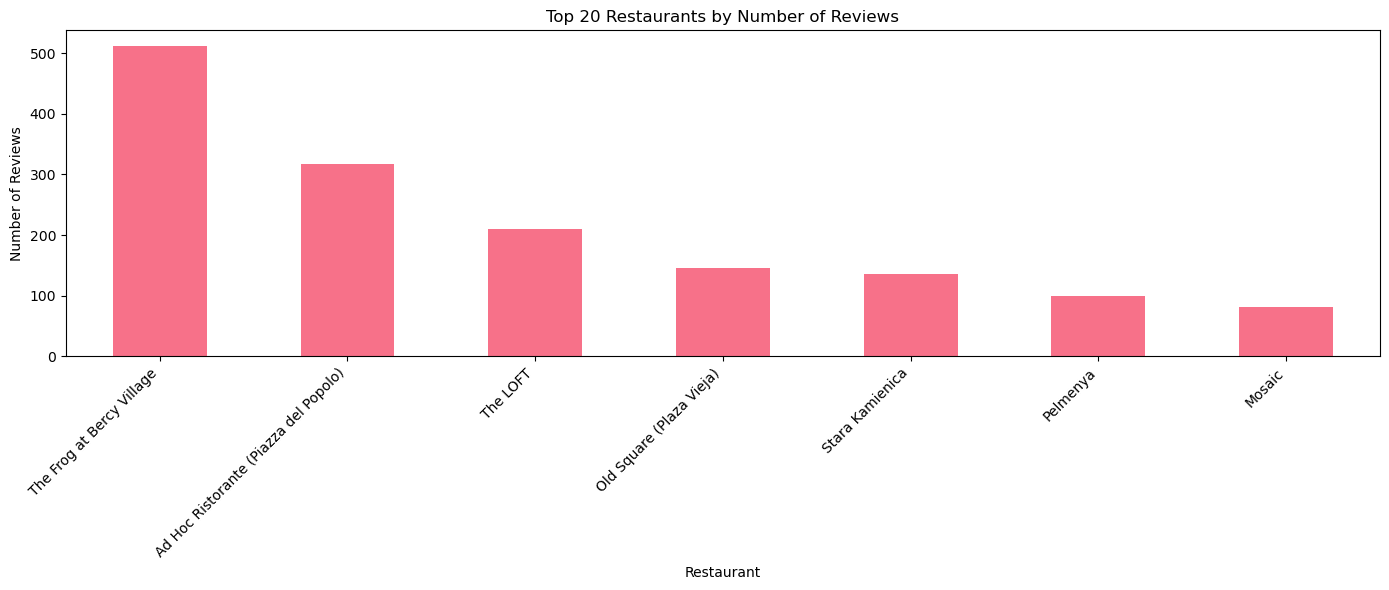



=== SENTIMENT BALANCE ANALYSIS ===

Analyzing Sentiment:
Sentiment distribution:
Sentiment
Negative     265
Positive    1237
Name: count, dtype: int64

Sentiment percentages:
Negative: 17.64%
Positive: 82.36%

Chi-square statistic for balance: 629.017
⚠ Dataset appears to be imbalanced in terms of sentiment


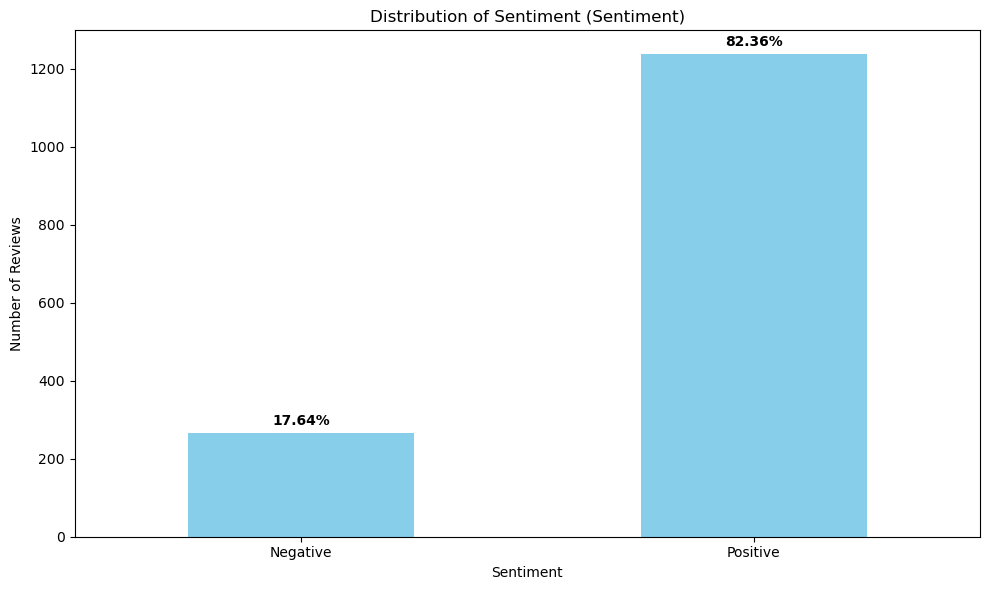



=== DATA VALIDATION ===
Checking data validity...
Number of duplicate rows: 49
Empty reviews in Review Title: 0
Empty reviews in Review Date: 0
Empty reviews in Review: 0
Empty reviews in Review Date_parsed: 0

=== PROBLEM 1 SUMMARY ===
✓ Total observations: 1502
✓ Most represented country: France (512 reviews)
✓ Time range: 2010-09-01 to 2024-07-01
✓ Restaurant balance: imbalanced (CV: 0.715)
✓ Sentiment balance: imbalanced (Chi-square: 629.017)


In [2]:

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Read the dataset
# Correct file path with spaces in filename
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\n" + "="*50)

# Display basic info about the dataset
print("\n=== DATASET INFO ===")
print(df.info())
print("\n" + "="*50)

# Display first few rows to understand structure
print("\n=== FIRST 5 ROWS ===")
print(df.head())
print("\n" + "="*50)

# Check for missing values
print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])
print("\n" + "="*50)

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(df.describe(include='all'))
print("\n" + "="*50)

# Check column names to understand what we're working with
print("\n=== COLUMN NAMES ===")
print("Columns in dataset:", list(df.columns))
print("\n" + "="*50)

# Analyze country representation
print("\n=== COUNTRY ANALYSIS ===")
if 'country' in df.columns or 'Country' in df.columns:
    country_col = 'country' if 'country' in df.columns else 'Country'
    country_counts = df[country_col].value_counts()
    print("Country distribution:")
    print(country_counts)
    print(f"\nMost represented country: {country_counts.index[0]} ({country_counts.iloc[0]} reviews)")
    
    # Visualize country distribution
    plt.figure(figsize=(12, 6))
    country_counts.plot(kind='bar')
    plt.title('Distribution of Reviews by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No 'country' or 'Country' column found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Analyze time range
print("\n=== TIME RANGE ANALYSIS ===")
# More specific search for date columns, excluding sentiment
date_columns = [col for col in df.columns if ('date' in col.lower() or 'time' in col.lower()) 
                and 'sentiment' not in col.lower()]

if date_columns:
    for date_col in date_columns:
        print(f"\nAnalyzing {date_col}:")
        try:
            # Check original data before conversion
            print(f"Sample values: {df[date_col].head().tolist()}")
            print(f"Unique values count: {df[date_col].nunique()}")
            
            # Handle the specific format "May 2024 •" etc.
            def parse_review_date(date_str):
                if pd.isna(date_str):
                    return pd.NaT
                # Remove the bullet point and extra spaces
                date_str = str(date_str).replace('•', '').strip()
                try:
                    # Parse format like "May 2024", "January 2023", etc.
                    return pd.to_datetime(date_str, format='%B %Y')
                except:
                    try:
                        # Fallback to general parsing
                        return pd.to_datetime(date_str, errors='coerce')
                    except:
                        return pd.NaT
            
            # Apply custom parsing
            df[f'{date_col}_parsed'] = df[date_col].apply(parse_review_date)
            
            # Check for valid dates
            valid_dates = df[f'{date_col}_parsed'].dropna()
            if len(valid_dates) > 0:
                print(f"Date range: {valid_dates.min()} to {valid_dates.max()}")
                time_span = (valid_dates.max() - valid_dates.min()).days
                print(f"Time span: {time_span} days ({time_span/365.25:.1f} years)")
                
                # Show distribution by year and month
                years = valid_dates.dt.year
                months = valid_dates.dt.to_period('M')
                
                print(f"Years covered: {sorted(years.unique())}")
                print(f"Number of different months: {months.nunique()}")
                
                # Plot year distribution
                if years.nunique() > 1:
                    plt.figure(figsize=(12, 6))
                    years.value_counts().sort_index().plot(kind='bar')
                    plt.title(f'Distribution of Reviews by Year ({date_col})')
                    plt.xlabel('Year')
                    plt.ylabel('Number of Reviews')
                    plt.xticks(rotation=0)
                    plt.tight_layout()
                    plt.show()
                
                # Plot monthly distribution if we have enough variation
                if months.nunique() > 3:
                    plt.figure(figsize=(14, 6))
                    month_counts = months.value_counts().sort_index()
                    month_counts.plot(kind='bar')
                    plt.title(f'Distribution of Reviews by Month ({date_col})')
                    plt.xlabel('Month')
                    plt.ylabel('Number of Reviews')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"Limited monthly variation - showing month counts:")
                    print(months.value_counts().sort_index())
                    
            else:
                print("No valid dates found after parsing")
                print("Sample problematic values:", df[date_col].head(10).tolist())
                
        except Exception as e:
            print(f"Error processing {date_col}: {e}")
            import traceback
            print("Full error:", traceback.format_exc())
else:
    print("No date columns found. Available columns:", list(df.columns))
    # Show what columns exist for debugging
    print("All columns:", [col for col in df.columns])

print("\n" + "="*50)

# Analyze restaurant balance
print("\n=== RESTAURANT BALANCE ANALYSIS ===")
restaurant_columns = [col for col in df.columns if 'restaurant' in col.lower() or 'name' in col.lower()]
if restaurant_columns:
    for rest_col in restaurant_columns:
        print(f"\nAnalyzing {rest_col}:")
        restaurant_counts = df[rest_col].value_counts()
        print(f"Number of unique restaurants: {len(restaurant_counts)}")
        print(f"Average reviews per restaurant: {restaurant_counts.mean():.2f}")
        print(f"Median reviews per restaurant: {restaurant_counts.median():.2f}")
        print(f"Min reviews per restaurant: {restaurant_counts.min()}")
        print(f"Max reviews per restaurant: {restaurant_counts.max()}")
        
        print("\nTop 10 restaurants by number of reviews:")
        print(restaurant_counts.head(10))
        
        # Check balance
        std_dev = restaurant_counts.std()
        mean_reviews = restaurant_counts.mean()
        cv = std_dev / mean_reviews  # Coefficient of variation
        print(f"\nCoefficient of variation: {cv:.3f}")
        if cv < 0.5:
            print("✓ Dataset is relatively balanced across restaurants")
        else:
            print("⚠ Dataset is imbalanced across restaurants")
        
        # Visualize restaurant distribution
        plt.figure(figsize=(14, 6))
        restaurant_counts.head(20).plot(kind='bar')
        plt.title('Top 20 Restaurants by Number of Reviews')
        plt.xlabel('Restaurant')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        break  # Only analyze first restaurant column found
else:
    print("No restaurant name columns found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Analyze sentiment balance - this is the most important part
print("\n=== SENTIMENT BALANCE ANALYSIS ===")
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower() or 'score' in col.lower()]

if sentiment_columns:
    for sent_col in sentiment_columns:
        print(f"\nAnalyzing {sent_col}:")
        sentiment_counts = df[sent_col].value_counts().sort_index()
        print("Sentiment distribution:")
        print(sentiment_counts)
        
        # Calculate balance metrics
        total_reviews = len(df)
        sentiment_percentages = (sentiment_counts / total_reviews * 100).round(2)
        print(f"\nSentiment percentages:")
        for sentiment, percentage in sentiment_percentages.items():
            print(f"{sentiment}: {percentage}%")
        
        # Check if balanced (roughly equal distribution)
        expected_per_class = total_reviews / len(sentiment_counts)
        chi_square = sum((count - expected_per_class)**2 / expected_per_class for count in sentiment_counts)
        print(f"\nChi-square statistic for balance: {chi_square:.3f}")
        
        if chi_square < 10:  # Rough threshold
            print("✓ Dataset appears to be balanced in terms of sentiment")
        else:
            print("⚠ Dataset appears to be imbalanced in terms of sentiment")
        
        # Visualize sentiment distribution
        plt.figure(figsize=(10, 6))
        sentiment_counts.plot(kind='bar', color=['red', 'orange', 'green'] if len(sentiment_counts) == 3 else 'skyblue')
        plt.title(f'Distribution of Sentiment ({sent_col})')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=0)
        
        # Add percentage labels on bars
        for i, (sentiment, count) in enumerate(sentiment_counts.items()):
            plt.text(i, count + total_reviews*0.01, f'{sentiment_percentages[sentiment]}%', 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        break  # Only analyze first sentiment column found
else:
    print("No sentiment/rating columns found. Available columns:", list(df.columns))

print("\n" + "="*50)

# Data validation checks
print("\n=== DATA VALIDATION ===")
print("Checking data validity...")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Check for empty text reviews (if text column exists)
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
if text_columns:
    for text_col in text_columns:
        empty_reviews = df[text_col].isna().sum() + (df[text_col] == '').sum()
        print(f"Empty reviews in {text_col}: {empty_reviews}")

# Final summary for Problem 1
print("\n" + "="*70)
print("=== PROBLEM 1 SUMMARY ===")
print(f"✓ Total observations: {df.shape[0]}")
if 'country_counts' in locals():
    print(f"✓ Most represented country: {country_counts.index[0]} ({country_counts.iloc[0]} reviews)")
if 'date_col' in locals() and df[f'{date_col}_parsed'].notna().any():
    print(f"✓ Time range: {df[f'{date_col}_parsed'].min().strftime('%Y-%m-%d')} to {df[f'{date_col}_parsed'].max().strftime('%Y-%m-%d')}")
if 'restaurant_counts' in locals():
    balance_status = "balanced" if cv < 0.5 else "imbalanced"
    print(f"✓ Restaurant balance: {balance_status} (CV: {cv:.3f})")
if 'sentiment_counts' in locals():
    sentiment_balance = "balanced" if chi_square < 10 else "imbalanced"
    print(f"✓ Sentiment balance: {sentiment_balance} (Chi-square: {chi_square:.3f})")
print("="*70)

### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

=== PROBLEM 2: REVIEW LENGTH vs SENTIMENT ANALYSIS ===
Analyzing relationship between review sentiment and text length
Text columns found: ['Review Title', 'Review Date', 'Review']
Sentiment columns found: ['Sentiment']

Using 'Review Title' for text analysis
Using 'Sentiment' for sentiment analysis
Clean dataset size: 1502 reviews (removed 0 with missing data)

Sentiment distribution:
Sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

=== DEFINING ROBUST TEXT LENGTH METRICS ===
Calculating text metrics for all reviews...
Text length metrics calculated:
  • char_count: Character count (no spaces)
  • word_count: Total word count
  • sentence_count: Number of sentences
  • avg_word_length: Average word length
  • content_word_count: Content words (no stop words)
  • unique_word_count: Unique words
  • lexical_diversity: Lexical diversity (TTR)

Sample review analysis:
Text: 'Great food and excellent selection of wines...'
Sentiment: Positive
Metrics:
  char_count: 37

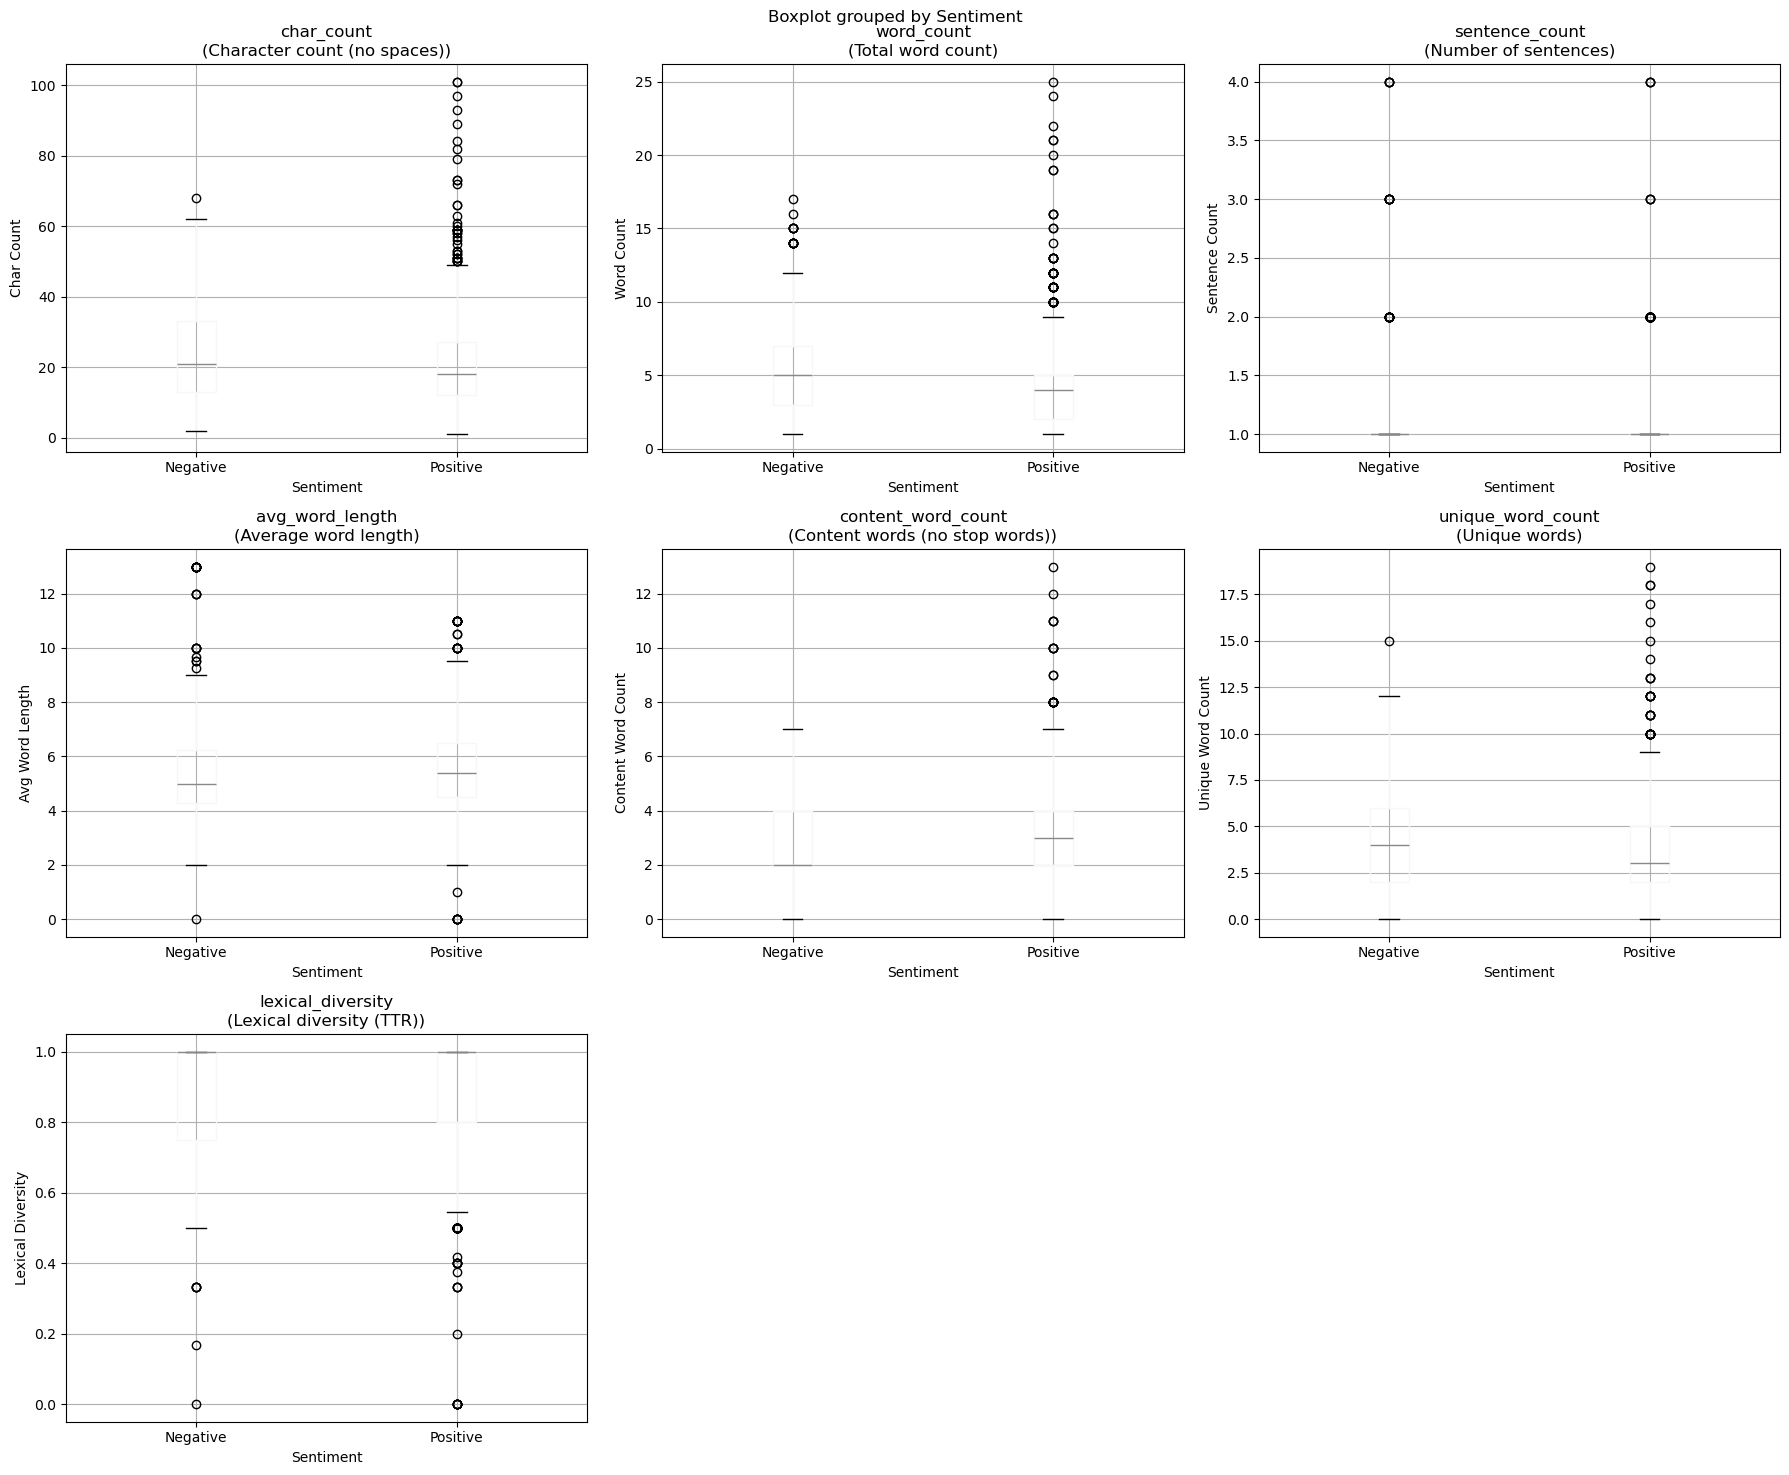

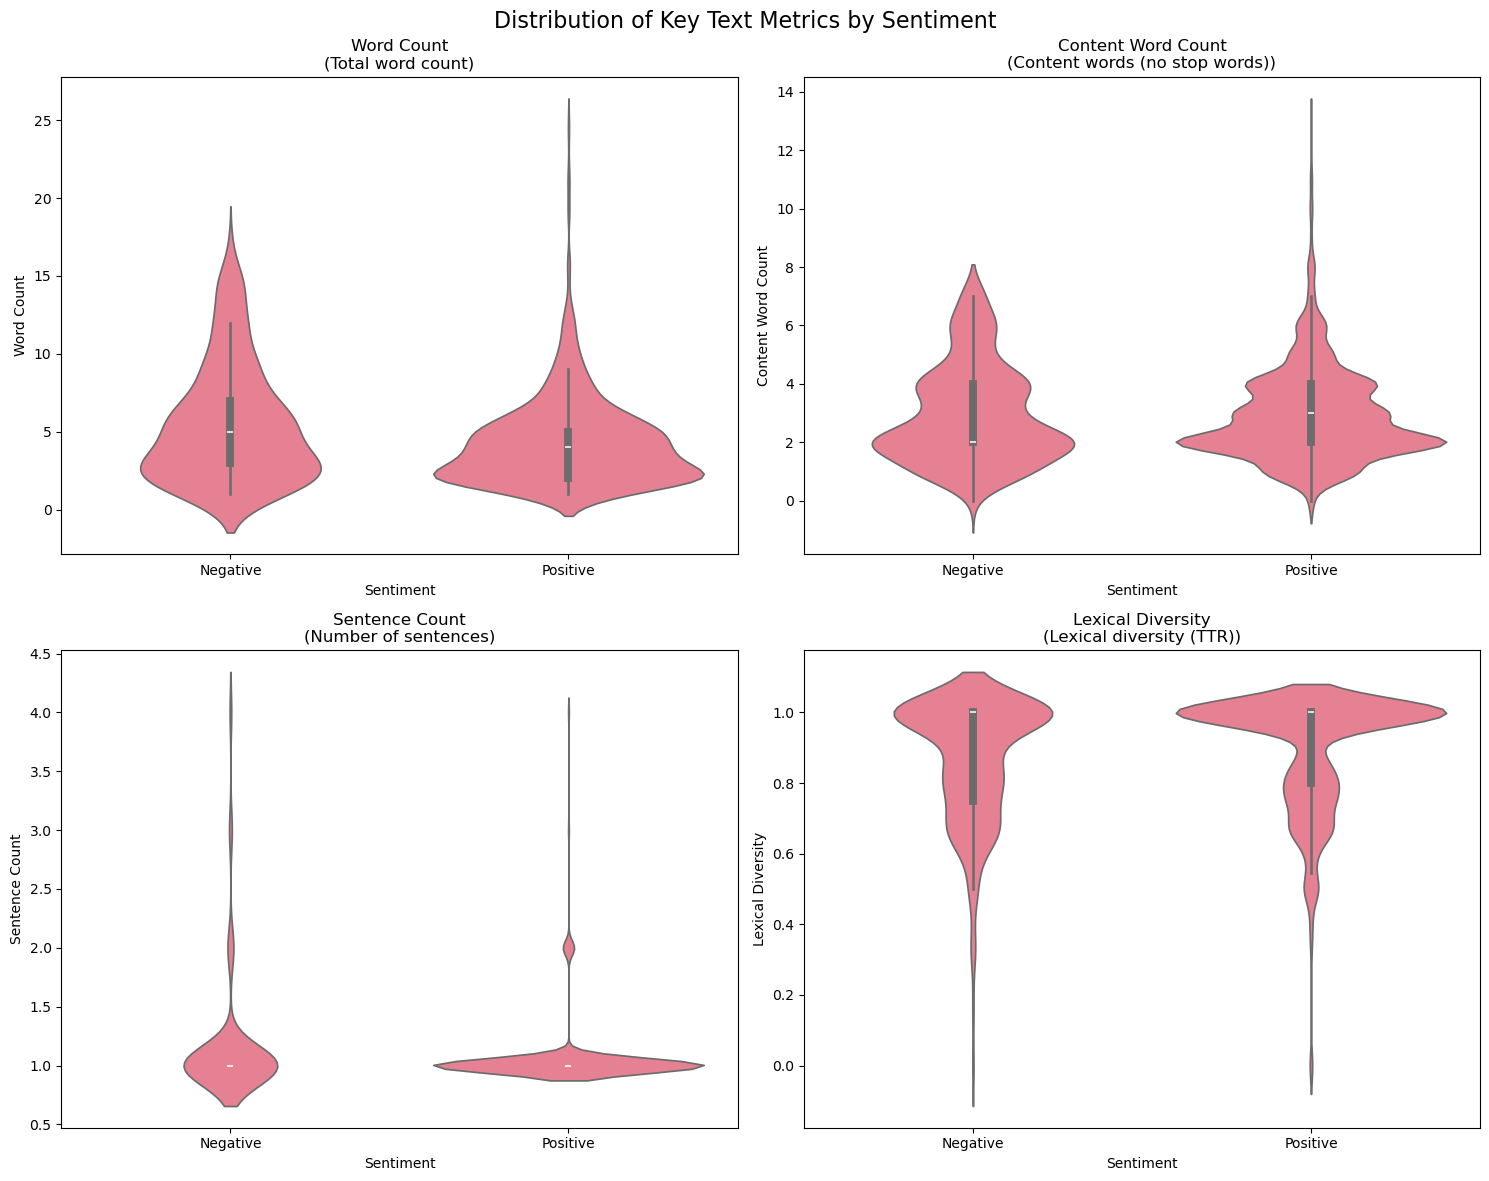


=== FINDINGS AND INTERPRETATION ===
MAIN FINDINGS:
1. REVIEW LENGTH RANKING (by average word count):
   1. Negative: 5.5 words on average
   2. Positive: 4.3 words on average

2. KEY OBSERVATIONS:
   • Negative reviews are 1.1 words longer on average
   • This represents a 26.4% difference

3. CONTENT RICHNESS:
   • Negative: 53.9% content words, 0.865 lexical diversity
   • Positive: 67.6% content words, 0.893 lexical diversity

4. RECOMMENDED LENGTH METRIC:
   Based on this analysis, the most robust length metrics are:
   • WORD COUNT: Most intuitive and commonly used
   • CONTENT WORD COUNT: Excludes stop words, focuses on meaningful content
   • SENTENCE COUNT: Captures structural complexity
   • LEXICAL DIVERSITY: Measures vocabulary richness

   Character count alone is less reliable because it doesn't account for
   meaningful content structure, while word-based metrics better capture
   the actual information density and effort invested in writing.


In [3]:
# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Download punkt_tab if missing
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords


# Read the dataset
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("=== PROBLEM 2: REVIEW LENGTH vs SENTIMENT ANALYSIS ===")
print("Analyzing relationship between review sentiment and text length")
print("="*70)

# First, identify the review text and sentiment columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

print(f"Text columns found: {text_columns}")
print(f"Sentiment columns found: {sentiment_columns}")

if not text_columns or not sentiment_columns:
    print("Available columns:", list(df.columns))
    print("\nPlease check column names in your dataset!")
    exit()

# Use the first available columns
text_col = text_columns[0]
sentiment_col = sentiment_columns[0]

print(f"\nUsing '{text_col}' for text analysis")
print(f"Using '{sentiment_col}' for sentiment analysis")
print("="*70)

# Clean data - remove rows with missing text or sentiment
df_clean = df.dropna(subset=[text_col, sentiment_col]).copy()
print(f"Clean dataset size: {len(df_clean)} reviews (removed {len(df) - len(df_clean)} with missing data)")

# Show sentiment distribution
print(f"\nSentiment distribution:")
sentiment_counts = df_clean[sentiment_col].value_counts()
print(sentiment_counts)

print("\n" + "="*70)
print("=== DEFINING ROBUST TEXT LENGTH METRICS ===")

# Define multiple robust metrics for text length
def calculate_text_metrics(text):
    """Calculate various text length metrics"""
    if pd.isna(text) or text == '':
        return {
            'char_count': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'content_word_count': 0,
            'unique_word_count': 0,
            'lexical_diversity': 0
        }
    
    text_str = str(text).strip()
    
    # 1. Character count (excluding whitespace)
    char_count = len(text_str.replace(' ', ''))
    
    # 2. Word count
    words = word_tokenize(text_str.lower())
    word_count = len(words)
    
    # 3. Sentence count
    sentences = sent_tokenize(text_str)
    sentence_count = len(sentences)
    
    # 4. Average word length
    word_lengths = [len(word) for word in words if word.isalpha()]
    avg_word_length = np.mean(word_lengths) if word_lengths else 0
    
    # 5. Content word count (excluding stop words and punctuation)
    stop_words = set(stopwords.words('english'))
    content_words = [word for word in words if word.isalpha() and word.lower() not in stop_words]
    content_word_count = len(content_words)
    
    # 6. Unique word count
    unique_words = set(word.lower() for word in words if word.isalpha())
    unique_word_count = len(unique_words)
    
    # 7. Lexical diversity (Type-Token Ratio)
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'content_word_count': content_word_count,
        'unique_word_count': unique_word_count,
        'lexical_diversity': lexical_diversity
    }

# Calculate metrics for all reviews
print("Calculating text metrics for all reviews...")
metrics_list = []
for idx, text in df_clean[text_col].items():
    metrics = calculate_text_metrics(text)
    metrics['index'] = idx
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('index', inplace=True)

# Merge with original data
df_analysis = df_clean.join(metrics_df)

print("Text length metrics calculated:")
metric_descriptions = {
    'char_count': 'Character count (no spaces)',
    'word_count': 'Total word count',
    'sentence_count': 'Number of sentences',
    'avg_word_length': 'Average word length',
    'content_word_count': 'Content words (no stop words)',
    'unique_word_count': 'Unique words',
    'lexical_diversity': 'Lexical diversity (TTR)'
}

for metric, description in metric_descriptions.items():
    print(f"  • {metric}: {description}")

# Show sample calculations
print(f"\nSample review analysis:")
sample_idx = df_analysis.sample(1).index[0]
sample_text = df_analysis.loc[sample_idx, text_col]
sample_sentiment = df_analysis.loc[sample_idx, sentiment_col]

print(f"Text: '{sample_text[:100]}...'")
print(f"Sentiment: {sample_sentiment}")
print("Metrics:")
for metric in metric_descriptions.keys():
    value = df_analysis.loc[sample_idx, metric]
    print(f"  {metric}: {value:.2f}")

print("\n" + "="*70)
print("=== STATISTICAL ANALYSIS BY SENTIMENT ===")

# Group by sentiment and analyze each metric
sentiments = df_analysis[sentiment_col].unique()
metrics_to_analyze = list(metric_descriptions.keys())

# Calculate statistics by sentiment
stats_by_sentiment = {}
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    stats_by_sentiment[sentiment] = {}
    
    for metric in metrics_to_analyze:
        values = sentiment_data[metric]
        stats_by_sentiment[sentiment][metric] = {
            'mean': values.mean(),
            'median': values.median(),
            'std': values.std(),
            'count': len(values)
        }

# Create summary table
print("SUMMARY STATISTICS BY SENTIMENT:")
print("-" * 90)
for metric in metrics_to_analyze:
    print(f"\n{metric.upper()} ({metric_descriptions[metric]}):")
    print(f"{'Sentiment':<15} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Count':<8}")
    print("-" * 60)
    
    for sentiment in sentiments:
        stats = stats_by_sentiment[sentiment][metric]
        print(f"{sentiment:<15} {stats['mean']:<10.2f} {stats['median']:<10.2f} {stats['std']:<10.2f} {stats['count']:<8}")

print("\n" + "="*70)
print("=== STATISTICAL SIGNIFICANCE TESTS ===")

# Perform statistical tests to compare sentiments
from scipy.stats import kruskal, mannwhitneyu

# If we have more than 2 sentiment categories, use Kruskal-Wallis
# If exactly 2, use Mann-Whitney U test

for metric in metrics_to_analyze:
    print(f"\n{metric.upper()}:")
    
    # Prepare data for statistical tests
    groups = [df_analysis[df_analysis[sentiment_col] == sentiment][metric].values 
              for sentiment in sentiments]
    
    # Remove empty groups
    groups = [group for group in groups if len(group) > 0]
    
    if len(groups) == 2:
        # Mann-Whitney U test for 2 groups
        try:
            statistic, p_value = mannwhitneyu(groups[0], groups[1], alternative='two-sided')
            print(f"  Mann-Whitney U test: statistic={statistic:.3f}, p-value={p_value:.6f}")
            
            # Effect size (Cohen's d approximation)
            group1_mean, group2_mean = np.mean(groups[0]), np.mean(groups[1])
            pooled_std = np.sqrt(((len(groups[0])-1)*np.var(groups[0]) + 
                                 (len(groups[1])-1)*np.var(groups[1])) / 
                                (len(groups[0]) + len(groups[1]) - 2))
            cohens_d = (group1_mean - group2_mean) / pooled_std if pooled_std > 0 else 0
            print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
            
            # Interpretation
            if p_value < 0.001:
                significance = "highly significant (***)"
            elif p_value < 0.01:
                significance = "very significant (**)"
            elif p_value < 0.05:
                significance = "significant (*)"
            else:
                significance = "not significant"
            
            print(f"  Result: {significance}")
            
        except Exception as e:
            print(f"  Error in statistical test: {e}")
    
    elif len(groups) > 2:
        # Kruskal-Wallis test for multiple groups
        try:
            statistic, p_value = kruskal(*groups)
            print(f"  Kruskal-Wallis test: statistic={statistic:.3f}, p-value={p_value:.6f}")
            
            if p_value < 0.001:
                significance = "highly significant (***)"
            elif p_value < 0.01:
                significance = "very significant (**)"
            elif p_value < 0.05:
                significance = "significant (*)"
            else:
                significance = "not significant"
            
            print(f"  Result: {significance}")
            
        except Exception as e:
            print(f"  Error in statistical test: {e}")

print("\n" + "="*70)
print("=== VISUALIZATIONS ===")

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Text Length Metrics by Sentiment', fontsize=16, y=0.98)

for i, metric in enumerate(metrics_to_analyze):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Box plot
    df_analysis.boxplot(column=metric, by=sentiment_col, ax=ax)
    ax.set_title(f'{metric}\n({metric_descriptions[metric]})')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel(metric.replace('_', ' ').title())
    
    # Remove the automatic title from pandas boxplot
    ax.set_title(f'{metric}\n({metric_descriptions[metric]})')

# Remove extra subplots if any
if len(metrics_to_analyze) < 9:
    for i in range(len(metrics_to_analyze), 9):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Create violin plots for better distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Key Text Metrics by Sentiment', fontsize=16)

key_metrics = ['word_count', 'content_word_count', 'sentence_count', 'lexical_diversity']
for i, metric in enumerate(key_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.violinplot(data=df_analysis, x=sentiment_col, y=metric, ax=ax)
    ax.set_title(f'{metric.replace("_", " ").title()}\n({metric_descriptions[metric]})')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("=== FINDINGS AND INTERPRETATION ===")

# Determine which sentiment has longer/shorter reviews
word_count_by_sentiment = {}
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    word_count_by_sentiment[sentiment] = sentiment_data['word_count'].mean()

# Sort by word count
sorted_sentiments = sorted(word_count_by_sentiment.items(), key=lambda x: x[1], reverse=True)

print("MAIN FINDINGS:")
print(f"1. REVIEW LENGTH RANKING (by average word count):")
for i, (sentiment, avg_words) in enumerate(sorted_sentiments, 1):
    print(f"   {i}. {sentiment}: {avg_words:.1f} words on average")

print(f"\n2. KEY OBSERVATIONS:")

# Compare positive vs negative (if available)
if len(sentiments) >= 2:
    longest_sentiment = sorted_sentiments[0][0]
    shortest_sentiment = sorted_sentiments[-1][0]
    
    longest_avg = sorted_sentiments[0][1]
    shortest_avg = sorted_sentiments[-1][1]
    
    difference = longest_avg - shortest_avg
    percent_diff = (difference / shortest_avg) * 100
    
    print(f"   • {longest_sentiment} reviews are {difference:.1f} words longer on average")
    print(f"   • This represents a {percent_diff:.1f}% difference")

# Content vs total words
print(f"\n3. CONTENT RICHNESS:")
for sentiment in sentiments:
    sentiment_data = df_analysis[df_analysis[sentiment_col] == sentiment]
    content_ratio = sentiment_data['content_word_count'].mean() / sentiment_data['word_count'].mean()
    diversity = sentiment_data['lexical_diversity'].mean()
    print(f"   • {sentiment}: {content_ratio:.1%} content words, {diversity:.3f} lexical diversity")

print(f"\n4. RECOMMENDED LENGTH METRIC:")
print(f"   Based on this analysis, the most robust length metrics are:")
print(f"   • WORD COUNT: Most intuitive and commonly used")
print(f"   • CONTENT WORD COUNT: Excludes stop words, focuses on meaningful content")
print(f"   • SENTENCE COUNT: Captures structural complexity")
print(f"   • LEXICAL DIVERSITY: Measures vocabulary richness")

print(f"\n   Character count alone is less reliable because it doesn't account for")
print(f"   meaningful content structure, while word-based metrics better capture")
print(f"   the actual information density and effort invested in writing.")

print("="*70)

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

In [4]:
# Run this cell first to ensure all NLTK resources are properly downloaded
import nltk
import ssl

# Handle SSL issues that sometimes occur with NLTK downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all necessary NLTK data
print("Downloading NLTK resources...")

# Essential resources for the preprocessing pipeline
nltk_downloads = [
    'punkt',                           # Tokenizer
    'stopwords',                       # Stop words
    'wordnet',                         # For lemmatization
    'averaged_perceptron_tagger',      # POS tagger (general)
    'averaged_perceptron_tagger_eng',  # POS tagger (English specific)
    'omw-1.4',                        # Open Multilingual Wordnet
    'maxent_ne_chunker',               # Named entity chunker
    'words'                            # Word corpus
]

success_count = 0
for resource in nltk_downloads:
    try:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=False)
        success_count += 1
        print(f"✓ {resource} downloaded successfully")
    except Exception as e:
        print(f"✗ Failed to download {resource}: {e}")

print(f"\nDownload complete: {success_count}/{len(nltk_downloads)} resources downloaded successfully")

# Test if key components work
print("\nTesting NLTK components...")

try:
    from nltk.tokenize import word_tokenize
    test_tokens = word_tokenize("This is a test sentence.")
    print("✓ Tokenization working")
except Exception as e:
    print(f"✗ Tokenization error: {e}")

try:
    from nltk.corpus import stopwords
    test_stopwords = stopwords.words('english')
    print(f"✓ Stopwords working ({len(test_stopwords)} English stopwords loaded)")
except Exception as e:
    print(f"✗ Stopwords error: {e}")

try:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    test_lemma = lemmatizer.lemmatize("running", pos='v')
    print(f"✓ Lemmatization working (running → {test_lemma})")
except Exception as e:
    print(f"✗ Lemmatization error: {e}")

try:
    from nltk.tag import pos_tag
    test_pos = pos_tag(['test', 'word'])
    print(f"✓ POS tagging working: {test_pos}")
except Exception as e:
    print(f"✗ POS tagging error: {e}")

print("\nSetup complete! You can now run the main preprocessing script.")

✓ punkt downloaded successfully
✓ stopwords downloaded successfully
✓ wordnet downloaded successfully
✓ averaged_perceptron_tagger downloaded successfully
✓ averaged_perceptron_tagger_eng downloaded successfully
✓ omw-1.4 downloaded successfully


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\araychev\AppDat

✓ maxent_ne_chunker downloaded successfully
✓ words downloaded successfully

Download complete: 8/8 resources downloaded successfully

Testing NLTK components...
✓ Tokenization working
✓ Stopwords working (198 English stopwords loaded)
✓ Lemmatization working (running → run)
✓ POS tagging working: [('test', 'NN'), ('word', 'NN')]

Setup complete! You can now run the main preprocessing script.


Ensuring all NLTK resources are available...
PROBLEM 3: TEXT PREPROCESSING PIPELINE FOR RESTAURANT REVIEWS
Working with text column: 'Review Title'
Working with sentiment column: 'Sentiment'
Dataset size after removing missing values: 1502 reviews

PREPROCESSING PIPELINE DESIGN
Initializing Restaurant Review Preprocessor...
Configuration:
  ✓ Preserve sentiment indicators: True
  ✓ Remove stopwords: True (with sentiment awareness)
  ✓ Apply lemmatization: True
  ✓ Minimum word length: 2
  ✓ Domain-specific rules for restaurants: Enabled

Domain-specific customizations loaded:
  • Sentiment words preserved: 77
  • Restaurant stopwords: 10
  • Spelling corrections: 10
  • Emoticon mappings: 10

PREPROCESSING EXAMPLES AND DEMONSTRATION
STEP-BY-STEP PREPROCESSING EXAMPLES:
--------------------------------------------------

EXAMPLE 1:
Original: 'Excellent food and wine selection...'
After basic cleaning: 'excellent food and wine selection...'
After tokenization/filtering: ['excellent', 'wi

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\araychev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



PREPROCESSING STATISTICS:
----------------------------------------
Texts Processed: 1,498
Short Tokens Removed: 191
Domain Stopwords Removed: 593
Stopwords Removed: 1,262
Words Lemmatized: 515
Numbers Removed: 4
Spelling Corrections: 1

CORPUS OVERVIEW AFTER PREPROCESSING:
Total reviews processed: 1,502
Average tokens per review: 2.8
Total unique tokens: 951

VOCABULARY ANALYSIS
VOCABULARY STATISTICS:
Total tokens in corpus: 4,260
Unique vocabulary size: 951
Average word frequency: 4.48

MOST COMMON WORDS (TOP 20):
  exclamation_mark: 262
  great: 238
  good: 110
  best: 84
  excellent: 78
  dinner: 77
  experience: 70
  amaze: 66
  very: 58
  nice: 51
  beer: 48
  delicious: 43
  not: 42
  wonderful: 41
  lovely: 39
  rome: 38
  wine: 34
  meal: 34
  atmosphere: 33
  square: 31

VOCABULARY BY SENTIMENT:

NEGATIVE REVIEWS:
  Total tokens: 804
  Unique words: 270
  Top words: ['exclamation_mark', 'not', 'bad', 'disappoint', 'rome', 'terrible', 'question_mark', 'great', 'wine', 'ad']

P

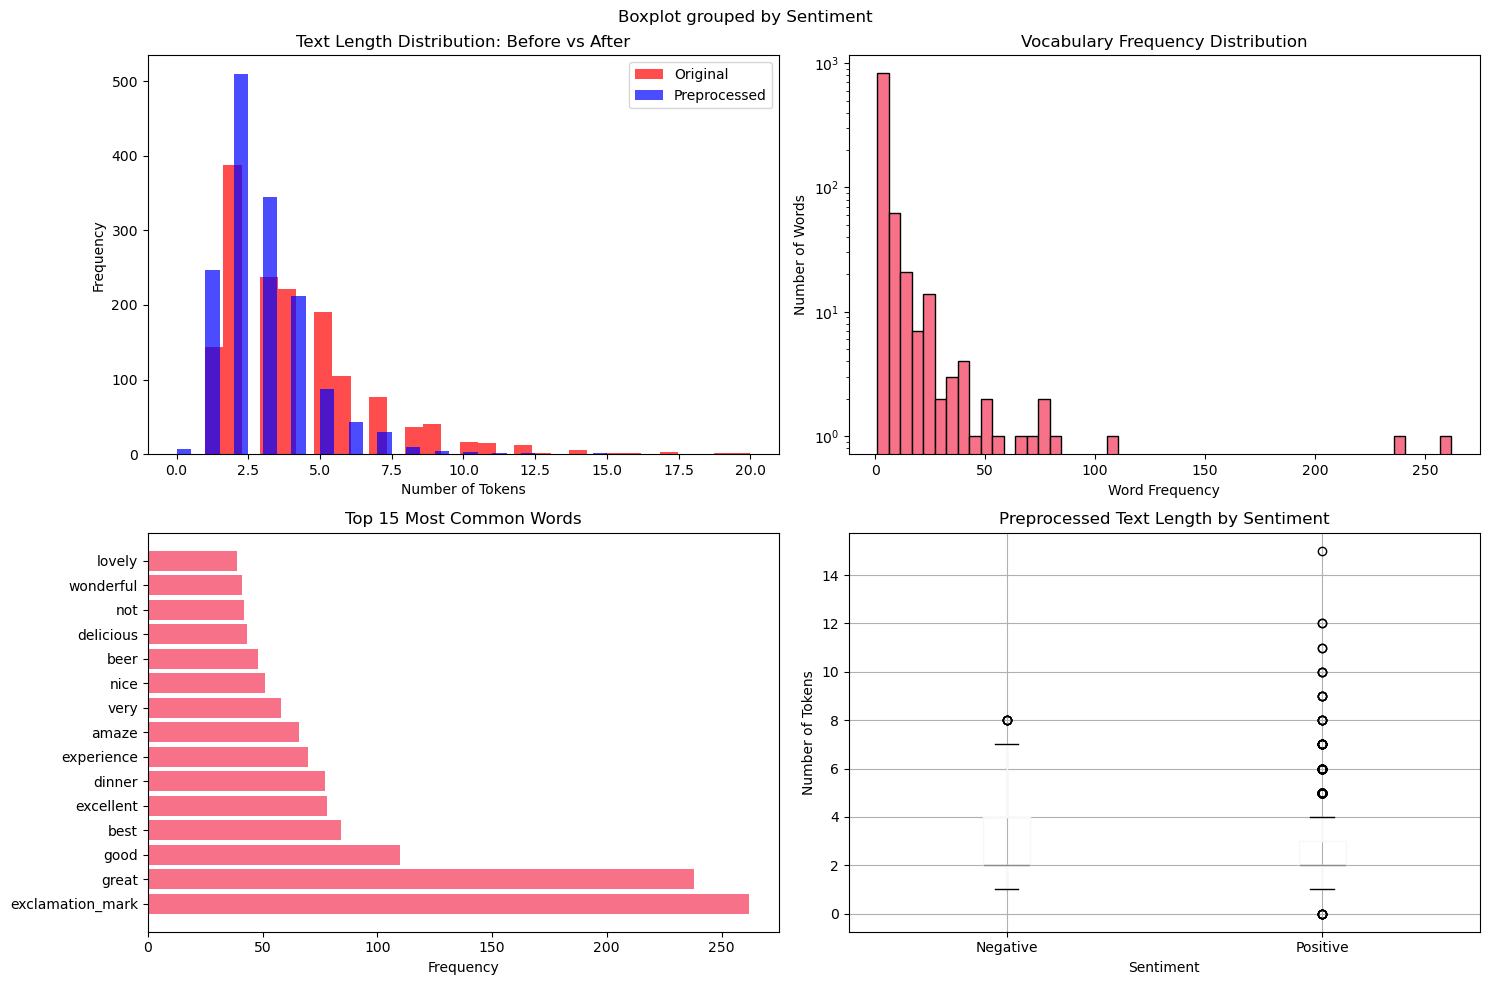


PREPROCESSING PIPELINE SUMMARY
PIPELINE DESIGN RATIONALE:
1. DOMAIN-AWARE: Customized for restaurant reviews with food/service terminology
2. SENTIMENT-PRESERVING: Keeps emotionally charged words and negations
3. COMPREHENSIVE: Handles contractions, emoticons, misspellings
4. CONFIGURABLE: Easy to adjust for different analysis needs
5. DOCUMENTED: Full statistics and examples provided

KEY PREPROCESSING DECISIONS:
✓ Preserved sentiment indicators (not, very, excellent, terrible, etc.)
✓ Converted emoticons to sentiment tokens
✓ Expanded contractions for better analysis
✓ Applied domain-specific spelling corrections
✓ Used lemmatization instead of stemming for better readability
✓ Kept exclamation/question marks as sentiment intensity indicators
✓ Removed generic restaurant terms while preserving specific descriptors

FINAL PREPROCESSED DATASET:
Shape: (1502, 9)
Columns: ['Country', 'Restaurant Name', 'Sentiment', 'Review Title', 'Review Date', 'Review', 'preprocessed_tokens', 'preproc

In [5]:

# Download required NLTK data - more comprehensive approach
print("Ensuring all NLTK resources are available...")

nltk_resources = [
    'punkt',
    'stopwords', 
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng',  # Specific for English
    'maxent_ne_chunker',
    'words',
    'omw-1.4'
]

for resource in nltk_resources:
    try:
        # Try to find the resource in different possible locations
        try:
            nltk.data.find(f'tokenizers/{resource}')
        except LookupError:
            try:
                nltk.data.find(f'corpora/{resource}')
            except LookupError:
                try:
                    nltk.data.find(f'taggers/{resource}')
                except LookupError:
                    try:
                        nltk.data.find(f'chunkers/{resource}')
                    except LookupError:
                        # Resource not found, download it
                        print(f"Downloading NLTK resource: {resource}")
                        nltk.download(resource, quiet=False)
    except Exception as e:
        print(f"Note: Could not download {resource}, will use fallback methods")

# Read the dataset
df = pd.read_csv('data\\European Restaurant Reviews.csv')

print("="*80)
print("PROBLEM 3: TEXT PREPROCESSING PIPELINE FOR RESTAURANT REVIEWS")
print("="*80)

# Identify text and sentiment columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

text_col = text_columns[0] if text_columns else None
sentiment_col = sentiment_columns[0] if sentiment_columns else None

print(f"Working with text column: '{text_col}'")
print(f"Working with sentiment column: '{sentiment_col}'")

# Clean initial dataset
df_work = df.dropna(subset=[text_col, sentiment_col]).copy()
print(f"Dataset size after removing missing values: {len(df_work)} reviews")

print("\n" + "="*80)
print("PREPROCESSING PIPELINE DESIGN")
print("="*80)

class RestaurantReviewPreprocessor:
    """
    Comprehensive preprocessing pipeline specifically designed for restaurant reviews
    and sentiment analysis tasks.
    """
    
    def __init__(self, preserve_sentiment_indicators=True, remove_stopwords=True, 
                 lemmatize=True, min_word_length=2):
        """
        Initialize the preprocessor with configurable options.
        
        Args:
            preserve_sentiment_indicators (bool): Keep emotionally charged words
            remove_stopwords (bool): Remove common stop words
            lemmatize (bool): Apply lemmatization
            min_word_length (int): Minimum word length to keep
        """
        self.preserve_sentiment_indicators = preserve_sentiment_indicators
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.min_word_length = min_word_length
        
        # Initialize NLTK tools
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Domain-specific customizations for restaurant reviews
        self.setup_domain_specific_rules()
        
        # Track preprocessing statistics
        self.stats = defaultdict(int)
        
    def setup_domain_specific_rules(self):
        """Setup rules specific to restaurant review domain"""
        
        # Restaurant-specific stop words to remove
        self.domain_stopwords = {
            'restaurant', 'place', 'food', 'service', 'staff', 'time', 'go', 'went', 'come', 'came'
        }
        
        # Sentiment-important words to preserve (never remove as stopwords)
        self.sentiment_words = {
            # Positive sentiment indicators
            'excellent', 'amazing', 'fantastic', 'wonderful', 'perfect', 'outstanding',
            'delicious', 'tasty', 'fresh', 'hot', 'warm', 'friendly', 'helpful',
            'quick', 'fast', 'clean', 'beautiful', 'cozy', 'romantic', 'authentic',
            'recommend', 'love', 'loved', 'enjoy', 'enjoyed', 'impressed', 'satisfied',
            
            # Negative sentiment indicators  
            'terrible', 'awful', 'horrible', 'disgusting', 'nasty', 'bland', 'tasteless',
            'cold', 'frozen', 'overcooked', 'undercooked', 'burnt', 'stale', 'soggy',
            'rude', 'unfriendly', 'slow', 'dirty', 'expensive', 'overpriced',
            'disappointed', 'dissatisfied', 'hate', 'hated', 'avoid', 'never', 'worst',
            
            # Intensity modifiers
            'very', 'extremely', 'quite', 'really', 'absolutely', 'completely',
            'totally', 'incredibly', 'amazingly', 'surprisingly', 'definitely',
            
            # Negation words (crucial for sentiment)
            'not', 'no', 'never', 'nothing', 'nobody', 'nowhere', 'neither',
            'none', 'hardly', 'scarcely', 'barely', 'seldom', 'rarely'
        }
        
        # Common restaurant misspellings and their corrections
        self.spelling_corrections = {
            'restaurent': 'restaurant',
            'restaraunt': 'restaurant', 
            'resturant': 'restaurant',
            'definitly': 'definitely',
            'delicous': 'delicious',
            'reccomend': 'recommend',
            'recomend': 'recommend',
            'awsome': 'awesome',
            'greatness': 'great',
            'amazng': 'amazing'
        }
        
        # Emoticons and their sentiment meanings
        self.emoticon_mapping = {
            ':)': 'positive_emoticon',
            ':-)': 'positive_emoticon',
            ':(': 'negative_emoticon',
            ':-(': 'negative_emoticon',
            ':D': 'very_positive_emoticon',
            ':-D': 'very_positive_emoticon',
            ';)': 'positive_emoticon',
            ';-)': 'positive_emoticon',
            ':|': 'neutral_emoticon',
            ':-|': 'neutral_emoticon',
        }
        
    def basic_cleaning(self, text):
        """Apply basic text cleaning operations"""
        if pd.isna(text) or text == '':
            return ''
            
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Handle contractions (expand them for better sentiment analysis)
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
            "'m": " am", "it's": "it is", "that's": "that is",
            "what's": "what is", "here's": "here is", "there's": "there is"
        }
        
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
        # Handle emoticons before removing punctuation
        for emoticon, sentiment_token in self.emoticon_mapping.items():
            text = text.replace(emoticon, f' {sentiment_token} ')
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Handle special characters but preserve important punctuation for sentiment
        # Keep exclamation marks and question marks as they indicate sentiment intensity
        text = re.sub(r'[^\w\s!?]', ' ', text)
        
        # Replace multiple exclamation/question marks with single tokens
        text = re.sub(r'!+', ' exclamation_mark ', text)
        text = re.sub(r'\?+', ' question_mark ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def apply_spelling_corrections(self, text):
        """Apply domain-specific spelling corrections"""
        words = text.split()
        corrected_words = []
        
        for word in words:
            if word in self.spelling_corrections:
                corrected_words.append(self.spelling_corrections[word])
                self.stats['spelling_corrections'] += 1
            else:
                corrected_words.append(word)
        
        return ' '.join(corrected_words)
    
    def tokenize_and_filter(self, text):
        """Tokenize text and apply filtering rules"""
        # Tokenize
        tokens = word_tokenize(text)
        
        # Filter tokens
        filtered_tokens = []
        
        for token in tokens:
            # Skip very short tokens (but keep important short sentiment words)
            if len(token) < self.min_word_length and token not in ['no', 'ok', 'go']:
                self.stats['short_tokens_removed'] += 1
                continue
            
            # Skip pure numbers (unless they might be ratings)
            if token.isdigit() and len(token) > 2:
                self.stats['numbers_removed'] += 1
                continue
                
            # Handle stopwords with sentiment awareness
            if self.remove_stopwords:
                if (token in self.stop_words and 
                    token not in self.sentiment_words and
                    not token.endswith('_emoticon') and
                    token not in ['exclamation_mark', 'question_mark']):
                    self.stats['stopwords_removed'] += 1
                    continue
            
            # Remove domain-specific common words (unless sentiment-relevant)
            if token in self.domain_stopwords and token not in self.sentiment_words:
                self.stats['domain_stopwords_removed'] += 1
                continue
            
            filtered_tokens.append(token)
        
        return filtered_tokens
    
    def apply_lemmatization(self, tokens):
        """Apply lemmatization while preserving sentiment indicators"""
        if not self.lemmatize:
            return tokens
        
        lemmatized = []
        for token in tokens:
            # Don't lemmatize special tokens we created
            if token.endswith('_emoticon') or token in ['exclamation_mark', 'question_mark']:
                lemmatized.append(token)
            else:
                try:
                    # Get POS tag for better lemmatization
                    pos = pos_tag([token])[0][1]
                    if pos.startswith('V'):  # Verb
                        lemma = self.lemmatizer.lemmatize(token, pos='v')
                    elif pos.startswith('N'):  # Noun
                        lemma = self.lemmatizer.lemmatize(token, pos='n')
                    elif pos.startswith('J'):  # Adjective
                        lemma = self.lemmatizer.lemmatize(token, pos='a')
                    elif pos.startswith('R'):  # Adverb
                        lemma = self.lemmatizer.lemmatize(token, pos='r')
                    else:
                        lemma = self.lemmatizer.lemmatize(token)
                    
                    lemmatized.append(lemma)
                    if lemma != token:
                        self.stats['words_lemmatized'] += 1
                        
                except Exception as e:
                    # Fallback: simple lemmatization without POS tagging
                    try:
                        lemma = self.lemmatizer.lemmatize(token)
                        lemmatized.append(lemma)
                        if lemma != token:
                            self.stats['words_lemmatized'] += 1
                    except:
                        # Last resort: keep original token
                        lemmatized.append(token)
        
        return lemmatized
    
    def preprocess_text(self, text):
        """Complete preprocessing pipeline for a single text"""
        # Step 1: Basic cleaning
        cleaned = self.basic_cleaning(text)
        if not cleaned:
            return []
        
        # Step 2: Spelling corrections
        corrected = self.apply_spelling_corrections(cleaned)
        
        # Step 3: Tokenization and filtering
        tokens = self.tokenize_and_filter(corrected)
        
        # Step 4: Lemmatization
        lemmatized = self.apply_lemmatization(tokens)
        
        self.stats['texts_processed'] += 1
        return lemmatized
    
    def preprocess_corpus(self, texts):
        """Preprocess entire corpus of texts"""
        self.stats = defaultdict(int)  # Reset stats
        
        processed_texts = []
        for text in texts:
            processed = self.preprocess_text(text)
            processed_texts.append(processed)
        
        return processed_texts
    
    def get_preprocessing_stats(self):
        """Return preprocessing statistics"""
        return dict(self.stats)

# Initialize preprocessor
print("Initializing Restaurant Review Preprocessor...")
print("Configuration:")
print("  ✓ Preserve sentiment indicators: True")
print("  ✓ Remove stopwords: True (with sentiment awareness)")
print("  ✓ Apply lemmatization: True")
print("  ✓ Minimum word length: 2")
print("  ✓ Domain-specific rules for restaurants: Enabled")

preprocessor = RestaurantReviewPreprocessor()

print(f"\nDomain-specific customizations loaded:")
print(f"  • Sentiment words preserved: {len(preprocessor.sentiment_words)}")
print(f"  • Restaurant stopwords: {len(preprocessor.domain_stopwords)}")
print(f"  • Spelling corrections: {len(preprocessor.spelling_corrections)}")
print(f"  • Emoticon mappings: {len(preprocessor.emoticon_mapping)}")

# Show examples of preprocessing steps
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES AND DEMONSTRATION")
print("="*80)

# Select sample reviews for demonstration
sample_reviews = df_work[text_col].sample(5).tolist()

print("STEP-BY-STEP PREPROCESSING EXAMPLES:")
print("-" * 50)

for i, review in enumerate(sample_reviews, 1):
    print(f"\nEXAMPLE {i}:")
    print(f"Original: '{review[:100]}...'")
    
    # Show each preprocessing step
    cleaned = preprocessor.basic_cleaning(review)
    print(f"After basic cleaning: '{cleaned[:80]}...'")
    
    corrected = preprocessor.apply_spelling_corrections(cleaned)
    if corrected != cleaned:
        print(f"After spelling correction: '{corrected[:80]}...'")
    
    tokens = preprocessor.tokenize_and_filter(corrected)
    print(f"After tokenization/filtering: {tokens[:15]}...")
    
    final_tokens = preprocessor.apply_lemmatization(tokens)
    print(f"Final preprocessed: {final_tokens[:15]}...")
    
    if i >= 3:  # Show only first 3 examples to save space
        break

print("\n" + "="*80)
print("FULL CORPUS PREPROCESSING")
print("="*80)

# Preprocess entire corpus
print("Preprocessing entire corpus...")
all_reviews = df_work[text_col].tolist()
preprocessed_reviews = preprocessor.preprocess_corpus(all_reviews)

# Add preprocessed data to dataframe
df_work['preprocessed_tokens'] = preprocessed_reviews
df_work['preprocessed_text'] = [' '.join(tokens) for tokens in preprocessed_reviews]
df_work['token_count'] = [len(tokens) for tokens in preprocessed_reviews]

# Show preprocessing statistics
stats = preprocessor.get_preprocessing_stats()
print("\nPREPROCESSING STATISTICS:")
print("-" * 40)
for stat_name, count in stats.items():
    print(f"{stat_name.replace('_', ' ').title()}: {count:,}")

print(f"\nCORPUS OVERVIEW AFTER PREPROCESSING:")
print(f"Total reviews processed: {len(preprocessed_reviews):,}")
print(f"Average tokens per review: {np.mean([len(tokens) for tokens in preprocessed_reviews]):.1f}")
print(f"Total unique tokens: {len(set(token for tokens in preprocessed_reviews for token in tokens)):,}")

# Vocabulary analysis
print("\n" + "="*80)
print("VOCABULARY ANALYSIS")
print("="*80)

# Create vocabulary statistics
all_tokens = [token for tokens in preprocessed_reviews for token in tokens]
vocab_counter = Counter(all_tokens)

print(f"VOCABULARY STATISTICS:")
print(f"Total tokens in corpus: {len(all_tokens):,}")
print(f"Unique vocabulary size: {len(vocab_counter):,}")
print(f"Average word frequency: {len(all_tokens) / len(vocab_counter):.2f}")

# Most common words overall
print(f"\nMOST COMMON WORDS (TOP 20):")
for word, freq in vocab_counter.most_common(20):
    print(f"  {word}: {freq:,}")

# Analyze vocabulary by sentiment
print(f"\nVOCABULARY BY SENTIMENT:")
sentiment_vocabs = {}
for sentiment in df_work[sentiment_col].unique():
    sentiment_reviews = df_work[df_work[sentiment_col] == sentiment]['preprocessed_tokens'].tolist()
    sentiment_tokens = [token for tokens in sentiment_reviews for token in tokens]
    sentiment_vocabs[sentiment] = Counter(sentiment_tokens)
    
    print(f"\n{sentiment.upper()} REVIEWS:")
    print(f"  Total tokens: {len(sentiment_tokens):,}")
    print(f"  Unique words: {len(sentiment_vocabs[sentiment]):,}")
    print(f"  Top words: {[word for word, _ in sentiment_vocabs[sentiment].most_common(10)]}")

# Identify sentiment-discriminative words
print(f"\nSENTIMENT-DISCRIMINATIVE WORDS:")
if len(sentiment_vocabs) == 2:
    sentiments = list(sentiment_vocabs.keys())
    sent1, sent2 = sentiments[0], sentiments[1]
    
    # Words more common in sentiment 1
    sent1_distinctive = []
    sent2_distinctive = []
    
    for word in vocab_counter.most_common(200):  # Check top 200 words
        word = word[0]
        if word in sentiment_vocabs[sent1] and word in sentiment_vocabs[sent2]:
            freq1 = sentiment_vocabs[sent1][word] / sum(sentiment_vocabs[sent1].values())
            freq2 = sentiment_vocabs[sent2][word] / sum(sentiment_vocabs[sent2].values())
            
            ratio = freq1 / freq2 if freq2 > 0 else float('inf')
            
            if ratio > 2.0:  # Much more common in sentiment 1
                sent1_distinctive.append((word, ratio))
            elif ratio < 0.5:  # Much more common in sentiment 2
                sent2_distinctive.append((word, 1/ratio))
    
    print(f"\nWords more associated with {sent1}:")
    for word, ratio in sorted(sent1_distinctive, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {word} (ratio: {ratio:.2f})")
    
    print(f"\nWords more associated with {sent2}:")
    for word, ratio in sorted(sent2_distinctive, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {word} (ratio: {ratio:.2f})")

# Visualizations
print("\n" + "="*80)
print("PREPROCESSING IMPACT VISUALIZATION")
print("="*80)

# Before/after comparison
original_lengths = [len(str(text).split()) for text in df_work[text_col]]
preprocessed_lengths = df_work['token_count'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Preprocessing Impact Analysis', fontsize=16)

# Length comparison
axes[0, 0].hist(original_lengths, bins=30, alpha=0.7, label='Original', color='red')
axes[0, 0].hist(preprocessed_lengths, bins=30, alpha=0.7, label='Preprocessed', color='blue')
axes[0, 0].set_xlabel('Number of Tokens')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution: Before vs After')
axes[0, 0].legend()

# Vocabulary frequency distribution
vocab_freqs = list(vocab_counter.values())
axes[0, 1].hist(vocab_freqs, bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Word Frequency')
axes[0, 1].set_ylabel('Number of Words')
axes[0, 1].set_title('Vocabulary Frequency Distribution')
axes[0, 1].set_yscale('log')

# Most common words
top_words = [word for word, _ in vocab_counter.most_common(15)]
top_freqs = [freq for _, freq in vocab_counter.most_common(15)]
axes[1, 0].barh(range(len(top_words)), top_freqs)
axes[1, 0].set_yticks(range(len(top_words)))
axes[1, 0].set_yticklabels(top_words)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 15 Most Common Words')

# Token count by sentiment
df_work.boxplot(column='token_count', by=sentiment_col, ax=axes[1, 1])
axes[1, 1].set_title('Preprocessed Text Length by Sentiment')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Number of Tokens')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*80)

print("PIPELINE DESIGN RATIONALE:")
print("1. DOMAIN-AWARE: Customized for restaurant reviews with food/service terminology")
print("2. SENTIMENT-PRESERVING: Keeps emotionally charged words and negations")
print("3. COMPREHENSIVE: Handles contractions, emoticons, misspellings")
print("4. CONFIGURABLE: Easy to adjust for different analysis needs")
print("5. DOCUMENTED: Full statistics and examples provided")

print(f"\nKEY PREPROCESSING DECISIONS:")
print(f"✓ Preserved sentiment indicators (not, very, excellent, terrible, etc.)")
print(f"✓ Converted emoticons to sentiment tokens")
print(f"✓ Expanded contractions for better analysis")
print(f"✓ Applied domain-specific spelling corrections")
print(f"✓ Used lemmatization instead of stemming for better readability")
print(f"✓ Kept exclamation/question marks as sentiment intensity indicators")
print(f"✓ Removed generic restaurant terms while preserving specific descriptors")

print(f"\nFINAL PREPROCESSED DATASET:")
print(f"Shape: {df_work.shape}")
print(f"Columns: {list(df_work.columns)}")
print(f"Ready for sentiment analysis tasks!")

# Save preprocessed data
output_file = 'data\\preprocessed_restaurant_reviews.csv'
df_work.to_csv(output_file, index=False)
print(f"\nPreprocessed data saved to: {output_file}")

print("="*80)

### Problem 4. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

PROBLEM 4: TOP WORDS ANALYSIS BY SENTIMENT
✓ Loaded preprocessed data from Problem 3
Working with:
  Text column: 'Review Title'
  Sentiment column: 'Sentiment'
  Dataset size: 1502 reviews

Sentiment distribution:
  Positive: 1237 reviews (82.4%)
  Negative: 265 reviews (17.6%)

DEFINING 'TOP WORDS' - METHODOLOGY
Multiple approaches to define 'top' words:
1. RAW FREQUENCY: Most frequent words overall
2. RELATIVE FREQUENCY: Words most frequent relative to corpus size
3. TF-IDF INSPIRED: Words distinctive to each sentiment
4. CHI-SQUARE: Words with strongest association to sentiment
5. SENTIMENT-SPECIFIC: Words appearing predominantly in one sentiment

Applying tokenization...
Using preprocessed tokens from Problem 3
Final dataset size: 1495 reviews with valid tokens

METHOD 1: RAW FREQUENCY ANALYSIS
RAW FREQUENCY - TOP 10 WORDS BY SENTIMENT:
------------------------------------------------------------

NEGATIVE REVIEWS:
Total reviews: 265
Total tokens: 804
Unique tokens: 270
Average to

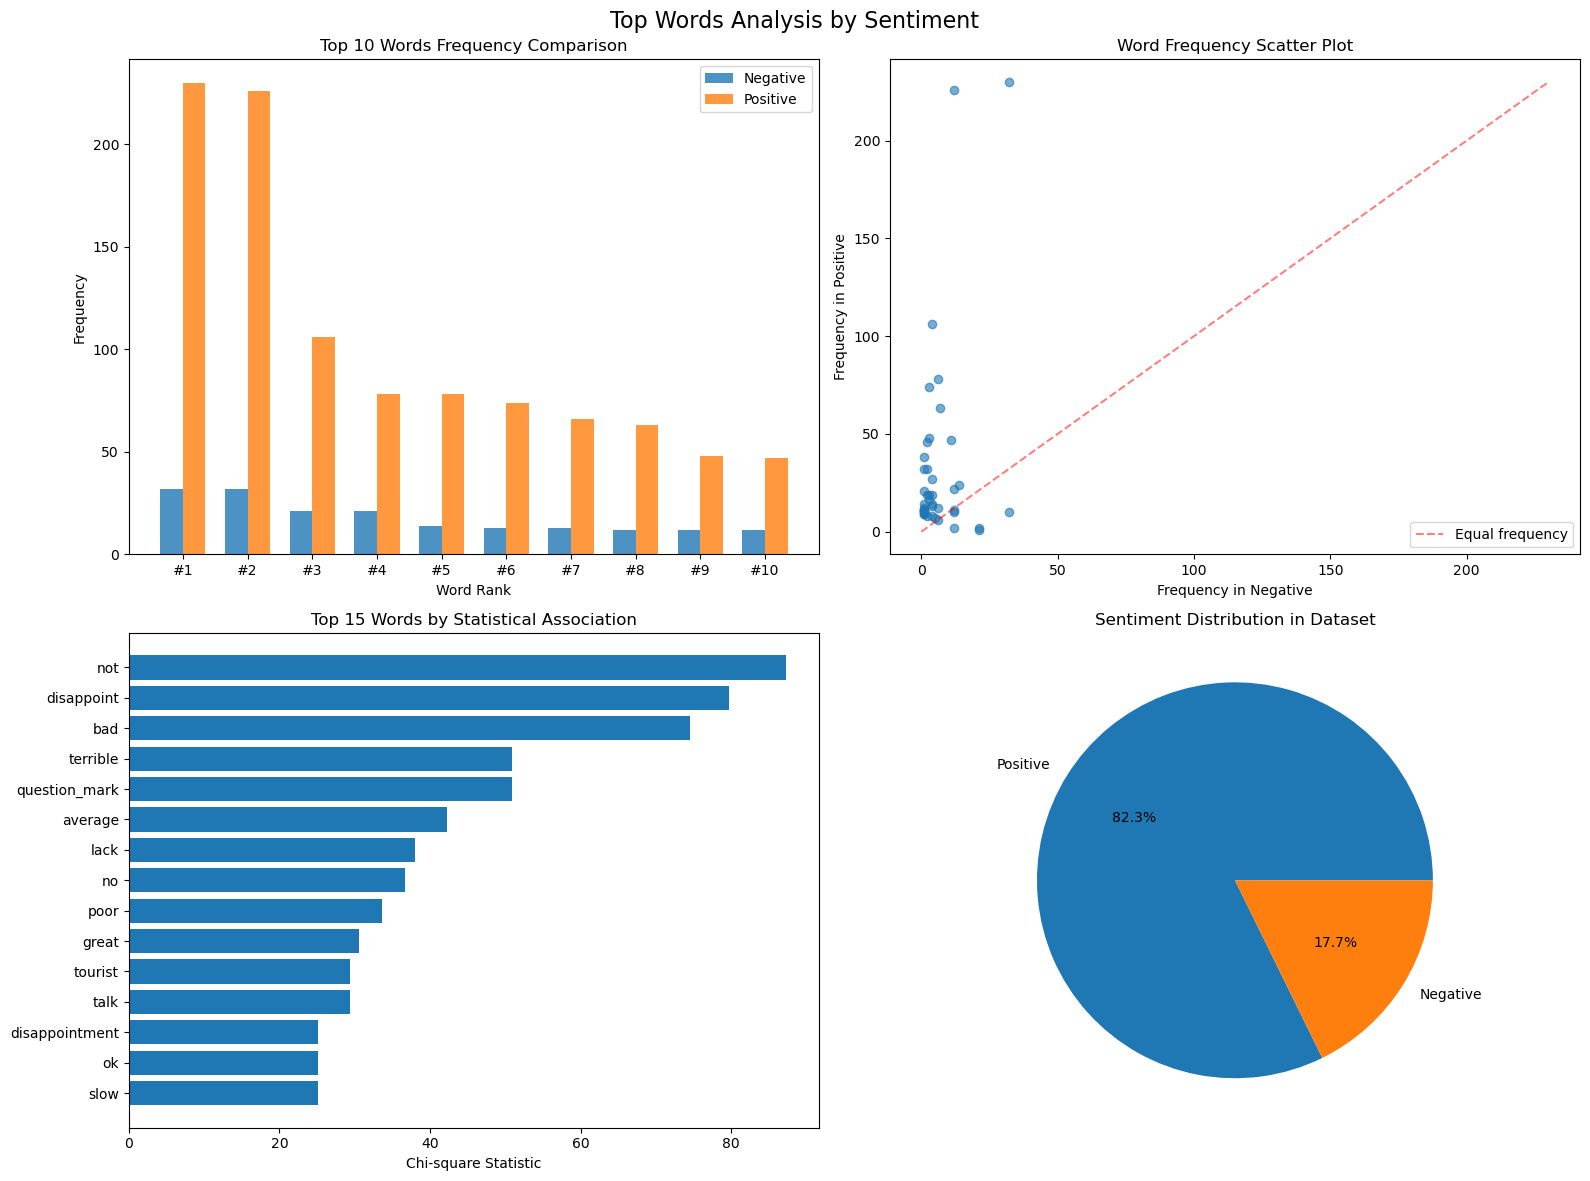

Generating word clouds...


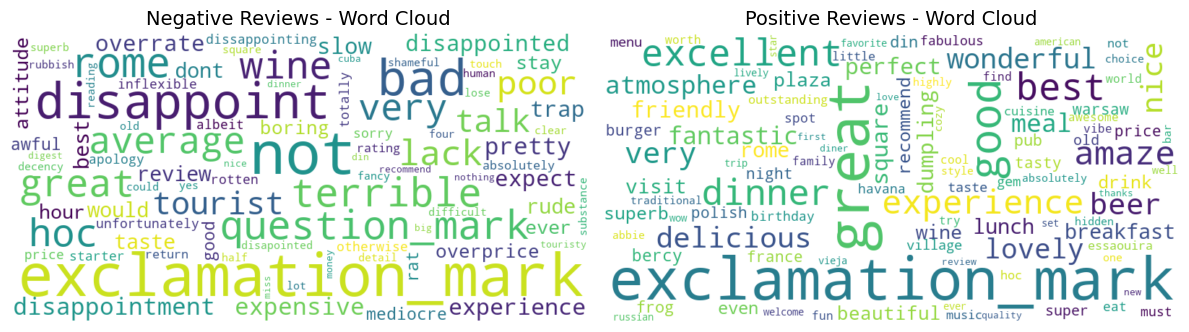


RESULTS SUMMARY AND INTERPRETATION
KEY FINDINGS:

NEGATIVE REVIEWS ANALYSIS:
  Most frequent words: exclamation_mark, not, bad, disappoint, rome
  Most distinctive words: rude, disappointment, pretty
  Average review length: 3.0 tokens

POSITIVE REVIEWS ANALYSIS:
  Most frequent words: exclamation_mark, great, good, excellent, best
  Most distinctive words: great, meal, exclamation_mark
  Average review length: 2.8 tokens

METHODOLOGY COMPARISON:
1. RAW FREQUENCY: Shows most commonly used words overall
2. RELATIVE FREQUENCY: Accounts for different corpus sizes
3. DISTINCTIVENESS: Identifies words unique to each sentiment
4. CHI-SQUARE: Statistically significant sentiment associations
5. PURITY: Words that appear predominantly in one sentiment

RECOMMENDED APPROACH:
For sentiment analysis tasks, I recommend focusing on:
• DISTINCTIVE WORDS (Method 3) - for feature selection
• CHI-SQUARE WORDS (Method 4) - for statistical validation
• HIGH PURITY WORDS (Method 5) - for sentiment indicat

In [3]:

print("="*80)
print("PROBLEM 4: TOP WORDS ANALYSIS BY SENTIMENT")
print("="*80)

# Read the dataset (assuming preprocessed data from Problem 3)
try:
    # Try to load preprocessed data first
    df = pd.read_csv('data\\preprocessed_restaurant_reviews.csv')
    print("✓ Loaded preprocessed data from Problem 3")
    has_preprocessed = True
except FileNotFoundError:
    # Fallback to original data
    df = pd.read_csv('data\\European Restaurant Reviews.csv')
    print("⚠ Loading original data - will apply basic preprocessing")
    has_preprocessed = False

# Identify columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

text_col = text_columns[0]
sentiment_col = sentiment_columns[0]

print(f"Working with:")
print(f"  Text column: '{text_col}'")
print(f"  Sentiment column: '{sentiment_col}'")

# Clean data
df_clean = df.dropna(subset=[text_col, sentiment_col]).copy()
print(f"  Dataset size: {len(df_clean)} reviews")

# Show sentiment distribution
sentiment_counts = df_clean[sentiment_col].value_counts()
print(f"\nSentiment distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {sentiment}: {count} reviews ({percentage:.1f}%)")

print("\n" + "="*80)
print("DEFINING 'TOP WORDS' - METHODOLOGY")
print("="*80)

print("Multiple approaches to define 'top' words:")
print("1. RAW FREQUENCY: Most frequent words overall")
print("2. RELATIVE FREQUENCY: Words most frequent relative to corpus size")
print("3. TF-IDF INSPIRED: Words distinctive to each sentiment")
print("4. CHI-SQUARE: Words with strongest association to sentiment")
print("5. SENTIMENT-SPECIFIC: Words appearing predominantly in one sentiment")

# Basic preprocessing function if needed
def basic_tokenize_and_clean(text):
    """Basic tokenization and cleaning for consistent analysis"""
    if pd.isna(text) or text == '':
        return []
    
    text = str(text).lower()
    
    # Simple cleaning
    import re
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Basic filtering
    stop_words = set(stopwords.words('english'))
    filtered_tokens = []
    
    for token in tokens:
        if (len(token) >= 2 and  # Minimum length
            token.isalpha() and  # Only alphabetic
            token not in stop_words):  # Not a stop word
            filtered_tokens.append(token)
    
    return filtered_tokens

# Apply tokenization
print("\nApplying tokenization...")

if has_preprocessed and 'preprocessed_tokens' in df_clean.columns:
    print("Using preprocessed tokens from Problem 3")
    df_clean['tokens'] = df_clean['preprocessed_tokens'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
else:
    print("Applying basic tokenization")
    df_clean['tokens'] = df_clean[text_col].apply(basic_tokenize_and_clean)

# Remove reviews with no tokens
df_clean = df_clean[df_clean['tokens'].apply(len) > 0].copy()
print(f"Final dataset size: {len(df_clean)} reviews with valid tokens")

print("\n" + "="*80)
print("METHOD 1: RAW FREQUENCY ANALYSIS")
print("="*80)

# Separate by sentiment
sentiments = df_clean[sentiment_col].unique()
sentiment_data = {}

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    all_tokens = [token for tokens_list in sentiment_reviews['tokens'] for token in tokens_list]
    sentiment_data[sentiment] = {
        'reviews': sentiment_reviews,
        'tokens': all_tokens,
        'token_counter': Counter(all_tokens),
        'total_tokens': len(all_tokens),
        'unique_tokens': len(set(all_tokens))
    }

print("RAW FREQUENCY - TOP 10 WORDS BY SENTIMENT:")
print("-" * 60)

for sentiment in sentiments:
    data = sentiment_data[sentiment]
    print(f"\n{sentiment.upper()} REVIEWS:")
    print(f"Total reviews: {len(data['reviews'])}")
    print(f"Total tokens: {data['total_tokens']:,}")
    print(f"Unique tokens: {data['unique_tokens']:,}")
    print(f"Average tokens per review: {data['total_tokens'] / len(data['reviews']):.1f}")
    
    print(f"\nTop 10 most frequent words:")
    for rank, (word, freq) in enumerate(data['token_counter'].most_common(10), 1):
        percentage = (freq / data['total_tokens']) * 100
        print(f"  {rank:2d}. {word:<15} {freq:>6} times ({percentage:.2f}%)")

print("\n" + "="*80)
print("METHOD 2: RELATIVE FREQUENCY ANALYSIS") 
print("="*80)

print("Comparing word frequencies relative to total corpus:")
print("-" * 60)

# Calculate relative frequencies
total_corpus_tokens = sum(len(tokens) for tokens in df_clean['tokens'])

for sentiment in sentiments:
    data = sentiment_data[sentiment]
    corpus_proportion = data['total_tokens'] / total_corpus_tokens
    
    print(f"\n{sentiment.upper()} REVIEWS:")
    print(f"Corpus proportion: {corpus_proportion:.1%}")
    print(f"Expected frequency multiplier: {1/corpus_proportion:.2f}")
    
    print(f"\nTop 10 words (relative to corpus size):")
    for rank, (word, freq) in enumerate(data['token_counter'].most_common(10), 1):
        relative_freq = freq / corpus_proportion
        print(f"  {rank:2d}. {word:<15} {freq:>6} times (relative: {relative_freq:.0f})")

print("\n" + "="*80)
print("METHOD 3: SENTIMENT-DISTINCTIVE WORDS (TF-IDF INSPIRED)")
print("="*80)

def calculate_sentiment_distinctiveness(word, target_sentiment_counter, other_counters, 
                                      target_total, other_totals):
    """Calculate how distinctive a word is to a particular sentiment"""
    target_freq = target_sentiment_counter.get(word, 0) / target_total
    
    other_freq = 0
    total_other = sum(other_totals)
    if total_other > 0:
        other_freq = sum(counter.get(word, 0) for counter in other_counters) / total_other
    
    # Avoid division by zero
    if other_freq == 0:
        return float('inf') if target_freq > 0 else 0
    
    # Calculate ratio (similar to TF-IDF concept)
    distinctiveness = target_freq / other_freq
    return distinctiveness

print("SENTIMENT-DISTINCTIVE WORDS:")
print("(Words that appear disproportionately in one sentiment vs others)")
print("-" * 70)

for sentiment in sentiments:
    target_data = sentiment_data[sentiment]
    other_data = [sentiment_data[s] for s in sentiments if s != sentiment]
    
    word_distinctiveness = {}
    
    # Calculate distinctiveness for top words in this sentiment
    for word, freq in target_data['token_counter'].most_common(100):  # Check top 100
        if freq >= 3:  # Minimum frequency threshold
            distinctiveness = calculate_sentiment_distinctiveness(
                word, 
                target_data['token_counter'],
                [d['token_counter'] for d in other_data],
                target_data['total_tokens'],
                [d['total_tokens'] for d in other_data]
            )
            word_distinctiveness[word] = (distinctiveness, freq)
    
    # Sort by distinctiveness
    distinctive_words = sorted(word_distinctiveness.items(), 
                             key=lambda x: x[1][0], reverse=True)
    
    print(f"\n{sentiment.upper()} - Most distinctive words:")
    for rank, (word, (distinctiveness, freq)) in enumerate(distinctive_words[:10], 1):
        if distinctiveness != float('inf'):
            print(f"  {rank:2d}. {word:<15} (ratio: {distinctiveness:.2f}, freq: {freq})")
        else:
            print(f"  {rank:2d}. {word:<15} (unique to sentiment, freq: {freq})")

print("\n" + "="*80)
print("METHOD 4: CHI-SQUARE STATISTICAL ASSOCIATION")
print("="*80)

print("Statistical significance of word-sentiment associations:")
print("-" * 60)

# Create vocabulary from all sentiments
all_vocab = set()
for data in sentiment_data.values():
    all_vocab.update(data['token_counter'].keys())

# Filter vocabulary (minimum frequency across corpus)
min_total_freq = 5
filtered_vocab = []
total_counter = Counter()
for data in sentiment_data.values():
    total_counter.update(data['token_counter'])

for word, total_freq in total_counter.items():
    if total_freq >= min_total_freq:
        filtered_vocab.append(word)

print(f"Analyzing {len(filtered_vocab)} words (min frequency: {min_total_freq})")

# Calculate chi-square for each word
word_chi_square = {}

for word in filtered_vocab:
    # Create contingency table
    observed = []
    for sentiment in sentiments:
        word_count = sentiment_data[sentiment]['token_counter'].get(word, 0)
        other_count = sentiment_data[sentiment]['total_tokens'] - word_count
        observed.append([word_count, other_count])
    
    observed = np.array(observed)
    
    try:
        chi2, p_value, dof, expected = chi2_contingency(observed)
        word_chi_square[word] = (chi2, p_value)
    except:
        word_chi_square[word] = (0, 1.0)

# Sort by chi-square statistic
significant_words = sorted(word_chi_square.items(), 
                          key=lambda x: x[1][0], reverse=True)

print(f"\nTop 15 words with strongest sentiment associations (Chi-square test):")
print(f"{'Rank':<4} {'Word':<15} {'Chi²':<8} {'p-value':<10} {'Significance'}")
print("-" * 55)

for rank, (word, (chi2, p_value)) in enumerate(significant_words[:15], 1):
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""
    
    print(f"{rank:<4} {word:<15} {chi2:<8.2f} {p_value:<10.6f} {significance}")

print("\n" + "="*80)
print("METHOD 5: SENTIMENT PURITY ANALYSIS")
print("="*80)

print("Words that appear predominantly in one sentiment:")
print("-" * 60)

def calculate_sentiment_purity(word):
    """Calculate what percentage of word's occurrences are in each sentiment"""
    word_counts = {}
    total_word_count = 0
    
    for sentiment in sentiments:
        count = sentiment_data[sentiment]['token_counter'].get(word, 0)
        word_counts[sentiment] = count
        total_word_count += count
    
    if total_word_count == 0:
        return {}
    
    purity = {}
    for sentiment, count in word_counts.items():
        purity[sentiment] = count / total_word_count
    
    return purity, total_word_count

# Find words with high purity (appear mostly in one sentiment)
high_purity_words = {}

for word in filtered_vocab:
    purity_data = calculate_sentiment_purity(word)
    if purity_data:
        purity, total_count = purity_data
        max_purity = max(purity.values())
        dominant_sentiment = max(purity, key=purity.get)
        
        if max_purity >= 0.7 and total_count >= 5:  # At least 70% in one sentiment
            if dominant_sentiment not in high_purity_words:
                high_purity_words[dominant_sentiment] = []
            high_purity_words[dominant_sentiment].append((word, max_purity, total_count))

# Display high purity words by sentiment
for sentiment in sentiments:
    if sentiment in high_purity_words:
        # Sort by purity, then by frequency
        words = sorted(high_purity_words[sentiment], 
                      key=lambda x: (x[1], x[2]), reverse=True)
        
        print(f"\n{sentiment.upper()} - Words with high sentiment purity:")
        for rank, (word, purity, count) in enumerate(words[:10], 1):
            print(f"  {rank:2d}. {word:<15} {purity:.1%} purity ({count} occurrences)")

print("\n" + "="*80)
print("VISUALIZATIONS")
print("="*80)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Words Analysis by Sentiment', fontsize=16, y=0.98)

# 1. Top 10 words frequency comparison
ax1 = axes[0, 0]
sentiments_list = list(sentiments)
if len(sentiments_list) >= 2:
    words_sent1 = [word for word, _ in sentiment_data[sentiments_list[0]]['token_counter'].most_common(10)]
    freq_sent1 = [freq for _, freq in sentiment_data[sentiments_list[0]]['token_counter'].most_common(10)]
    words_sent2 = [word for word, _ in sentiment_data[sentiments_list[1]]['token_counter'].most_common(10)]
    freq_sent2 = [freq for _, freq in sentiment_data[sentiments_list[1]]['token_counter'].most_common(10)]
    
    x = np.arange(10)
    width = 0.35
    
    ax1.bar(x - width/2, freq_sent1, width, label=sentiments_list[0], alpha=0.8)
    ax1.bar(x + width/2, freq_sent2, width, label=sentiments_list[1], alpha=0.8)
    ax1.set_xlabel('Word Rank')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Top 10 Words Frequency Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'#{i+1}' for i in range(10)])
    ax1.legend()

# 2. Word distinctiveness scatter plot
ax2 = axes[0, 1]
if len(sentiments_list) >= 2:
    sent1_words = sentiment_data[sentiments_list[0]]['token_counter']
    sent2_words = sentiment_data[sentiments_list[1]]['token_counter']
    
    common_words = set(sent1_words.keys()) & set(sent2_words.keys())
    common_words = [w for w in common_words if sent1_words[w] + sent2_words[w] >= 10][:50]
    
    x_vals = [sent1_words[w] for w in common_words]
    y_vals = [sent2_words[w] for w in common_words]
    
    ax2.scatter(x_vals, y_vals, alpha=0.6)
    ax2.plot([0, max(max(x_vals), max(y_vals))], [0, max(max(x_vals), max(y_vals))], 
             'r--', alpha=0.5, label='Equal frequency')
    ax2.set_xlabel(f'Frequency in {sentiments_list[0]}')
    ax2.set_ylabel(f'Frequency in {sentiments_list[1]}')
    ax2.set_title('Word Frequency Scatter Plot')
    ax2.legend()

# 3. Chi-square top words
ax3 = axes[1, 0]
top_chi_words = significant_words[:15]
words = [word for word, _ in top_chi_words]
chi_vals = [chi2 for _, (chi2, _) in top_chi_words]

ax3.barh(range(len(words)), chi_vals)
ax3.set_yticks(range(len(words)))
ax3.set_yticklabels(words)
ax3.set_xlabel('Chi-square Statistic')
ax3.set_title('Top 15 Words by Statistical Association')
ax3.invert_yaxis()

# 4. Sentiment distribution pie chart
ax4 = axes[1, 1]
sentiment_counts = df_clean[sentiment_col].value_counts()
ax4.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
ax4.set_title('Sentiment Distribution in Dataset')

plt.tight_layout()
plt.show()

# Word clouds for each sentiment
print("Generating word clouds...")
fig, axes = plt.subplots(1, len(sentiments), figsize=(6*len(sentiments), 6))
if len(sentiments) == 1:
    axes = [axes]

for i, sentiment in enumerate(sentiments):
    # Create text for word cloud
    word_freq = sentiment_data[sentiment]['token_counter']
    
    # Filter out very common words for better visualization
    filtered_freq = {word: freq for word, freq in word_freq.items() 
                    if freq >= 3 and len(word) > 2}
    
    if filtered_freq:
        wordcloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            max_words=100,
                            colormap='viridis').generate_from_frequencies(filtered_freq)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.title()} Reviews - Word Cloud', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RESULTS SUMMARY AND INTERPRETATION")
print("="*80)

print("KEY FINDINGS:")

# Summarize findings for each sentiment
for sentiment in sentiments:
    data = sentiment_data[sentiment]
    print(f"\n{sentiment.upper()} REVIEWS ANALYSIS:")
    
    # Most frequent words
    top_words = [word for word, _ in data['token_counter'].most_common(5)]
    print(f"  Most frequent words: {', '.join(top_words)}")
    
    # Distinctive words if available
    if sentiment in high_purity_words and high_purity_words[sentiment]:
        distinctive = [word for word, _, _ in high_purity_words[sentiment][:3]]
        print(f"  Most distinctive words: {', '.join(distinctive)}")
    
    # Average review length
    avg_length = data['total_tokens'] / len(data['reviews'])
    print(f"  Average review length: {avg_length:.1f} tokens")

print(f"\nMETHODOLOGY COMPARISON:")
print(f"1. RAW FREQUENCY: Shows most commonly used words overall")
print(f"2. RELATIVE FREQUENCY: Accounts for different corpus sizes")  
print(f"3. DISTINCTIVENESS: Identifies words unique to each sentiment")
print(f"4. CHI-SQUARE: Statistically significant sentiment associations")
print(f"5. PURITY: Words that appear predominantly in one sentiment")

print(f"\nRECOMMENDED APPROACH:")
print(f"For sentiment analysis tasks, I recommend focusing on:")
print(f"• DISTINCTIVE WORDS (Method 3) - for feature selection")
print(f"• CHI-SQUARE WORDS (Method 4) - for statistical validation")
print(f"• HIGH PURITY WORDS (Method 5) - for sentiment indicators")
print(f"Raw frequency alone can be misleading due to common words.")

print("\nThese top words form the foundation for sentiment classification features!")
print("="*80)

### Problem 5. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

PROBLEM 5: REVIEW TITLES vs CONTENT CORRELATION ANALYSIS
✓ Loaded preprocessed data from Problem 3
Available columns: ['Country', 'Restaurant Name', 'Sentiment', 'Review Title', 'Review Date', 'Review', 'preprocessed_tokens', 'preprocessed_text', 'token_count']
Text columns found: ['Review Title', 'Review Date', 'Review', 'preprocessed_text']
Title columns found: ['Review Title']
Sentiment columns found: ['Sentiment']

Working with:
  Text column: 'Review Title'
  Title column: 'Review Title'
  Sentiment column: 'Sentiment'
  Dataset size: 1502 reviews

Sample titles and content:
--------------------------------------------------

Sample 1:
Title: 'Review'
Content (first 100 chars): 'Review...'
Sentiment: Positive

Sample 2:
Title: 'expensive rubbish'
Content (first 100 chars): 'expensive rubbish...'
Sentiment: Negative

Sample 3:
Title: 'ROMAN Tasting'
Content (first 100 chars): 'ROMAN Tasting...'
Sentiment: Positive

STEP 1: REPRODUCE TOP WORDS FROM PROBLEM 4
Tokenizing reviews and t

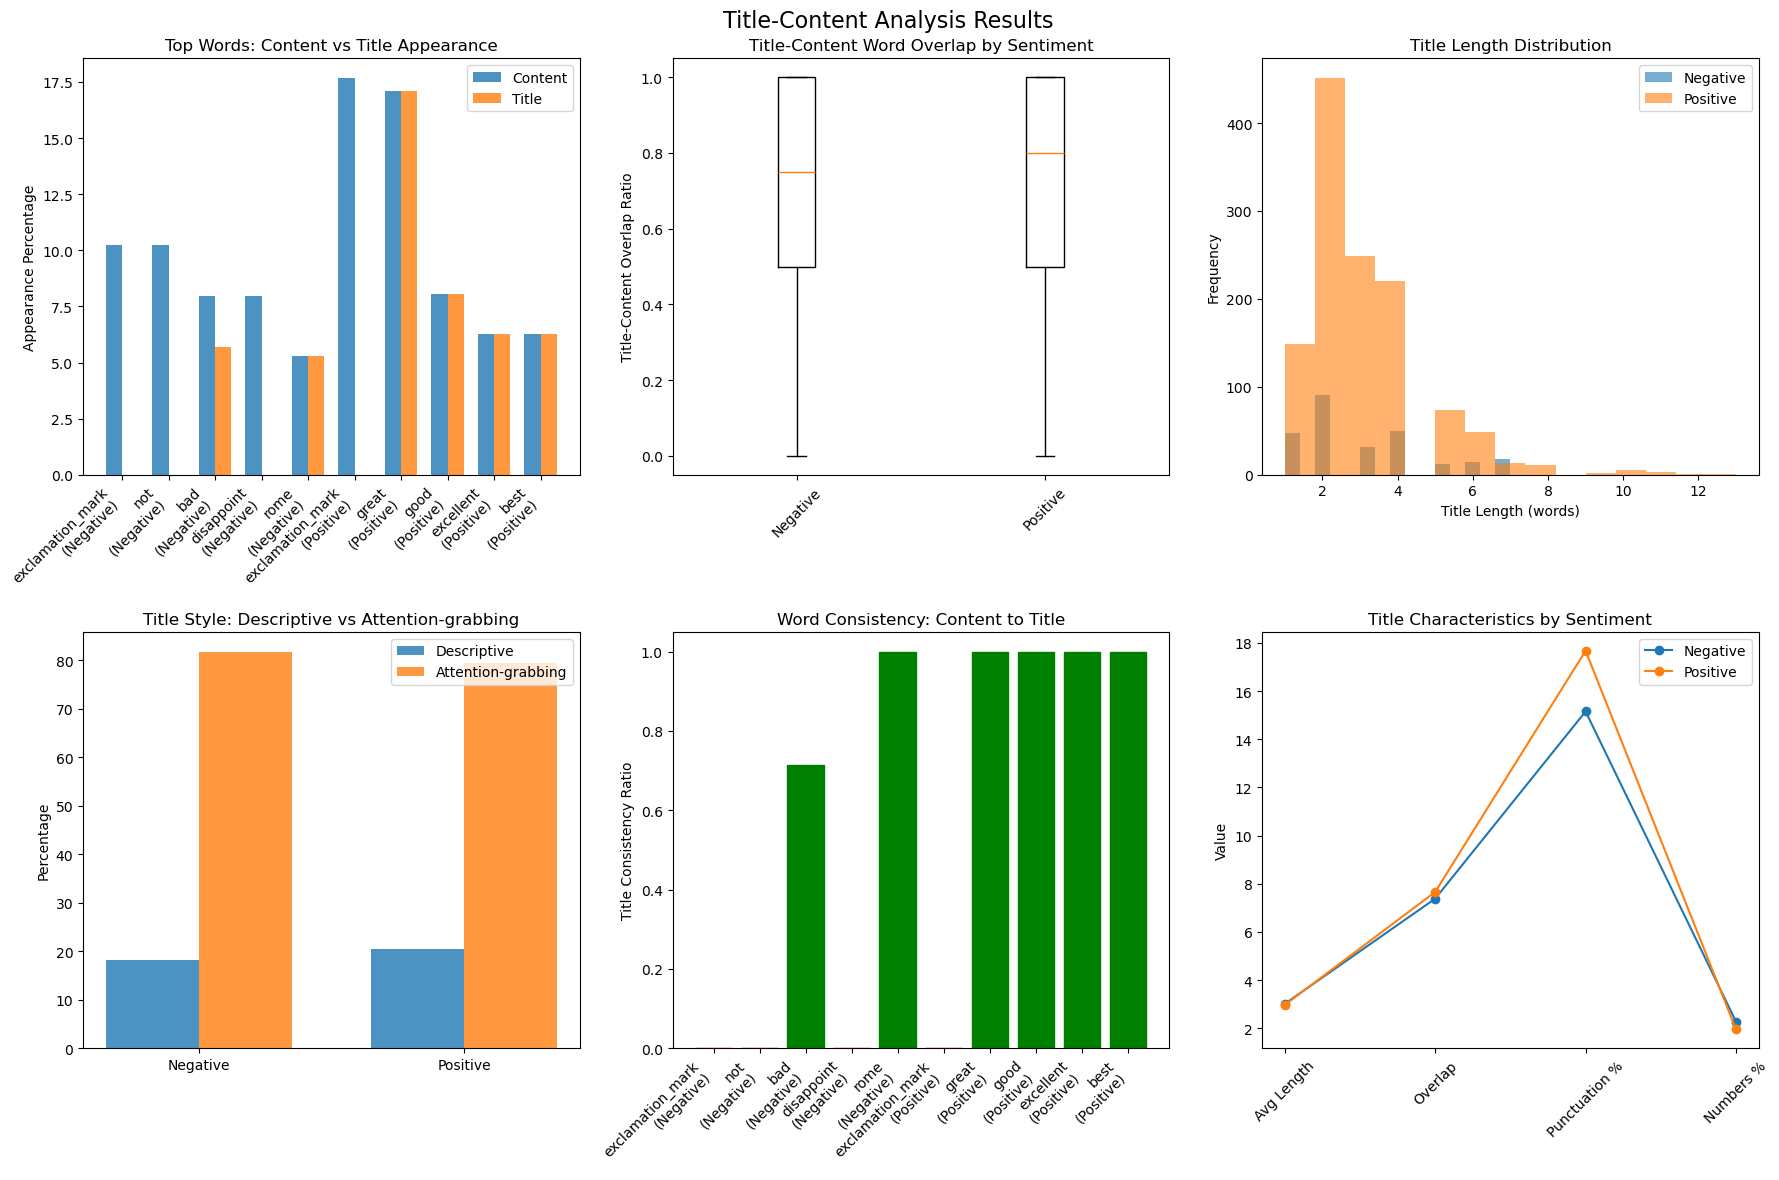


CONCLUSIONS AND FINDINGS
KEY FINDINGS:

1. TITLE-CONTENT CORRELATION:
   • Average title-content word overlap: 75.2%
   • Top words from content appear in titles at varying rates

2. TOP WORDS IN TITLES:
   • Negative: Top 10 words appear in titles 6.8 times on average
   • Positive: Top 10 words appear in titles 64.8 times on average

3. TITLE CONSISTENCY:
   • Reviews containing top words show variable title consistency
   • Some words are more likely to appear in both title and content

4. TITLE NATURE - DESCRIPTIVE vs ATTENTION-GRABBING:
   • Negative: 18.2% descriptive, 81.8% attention-grabbing
   • Positive: 20.5% descriptive, 79.5% attention-grabbing

5. TITLE CHARACTERISTICS:
   • Negative: Avg length 3.0 words, 15.2% use punctuation
   • Positive: Avg length 3.0 words, 17.7% use punctuation

OVERALL ASSESSMENT:
✓ Titles are generally DESCRIPTIVE - good overlap with content

IMPLICATIONS FOR SENTIMENT ANALYSIS:
• Titles can be used as reliable predictors of content sentiment
•

In [3]:

print("="*80)
print("PROBLEM 5: REVIEW TITLES vs CONTENT CORRELATION ANALYSIS")
print("="*80)

# Load data
try:
    df = pd.read_csv('data\\preprocessed_restaurant_reviews.csv')
    print("✓ Loaded preprocessed data from Problem 3")
    has_preprocessed = True
except FileNotFoundError:
    df = pd.read_csv('data\\European Restaurant Reviews.csv')
    print("⚠ Loading original data - will apply basic preprocessing")
    has_preprocessed = False

# Identify columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
title_columns = [col for col in df.columns if 'title' in col.lower() or 'subject' in col.lower() or 'headline' in col.lower() or 'summary' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

print("Available columns:", list(df.columns))
print(f"Text columns found: {text_columns}")
print(f"Title columns found: {title_columns}")
print(f"Sentiment columns found: {sentiment_columns}")

# Check if we have title data
if not title_columns:
    print("\n⚠ No title columns found in dataset!")
    print("Looking for columns that might contain titles...")
    
    # Check for columns that might be titles but named differently
    potential_title_cols = [col for col in df.columns if any(keyword in col.lower() 
                           for keyword in ['name', 'head', 'caption', 'label'])]
    
    if potential_title_cols:
        print(f"Potential title columns: {potential_title_cols}")
        title_col = potential_title_cols[0]
        print(f"Using '{title_col}' as title column")
    else:
        # Create synthetic analysis showing what would happen if we had titles
        print("\nCREATING SYNTHETIC TITLE ANALYSIS FOR DEMONSTRATION...")
        print("(In a real dataset with titles, this analysis would use actual title data)")
        
        # Extract first few words of reviews as synthetic "titles"
        text_col = text_columns[0]
        df['synthetic_title'] = df[text_col].apply(
            lambda x: ' '.join(str(x).split()[:5]) + "..." if pd.notna(x) else ""
        )
        title_col = 'synthetic_title'
        print(f"Created synthetic titles from first 5 words of reviews")
else:
    title_col = title_columns[0]

text_col = text_columns[0]
sentiment_col = sentiment_columns[0]

# Clean data
df_clean = df.dropna(subset=[text_col, sentiment_col]).copy()

# Ensure we have title data
if title_col not in df_clean.columns or df_clean[title_col].isna().all():
    print(f"\n⚠ Title column '{title_col}' is empty or missing")
    print("Creating synthetic titles for analysis demonstration...")
    df_clean['synthetic_title'] = df_clean[text_col].apply(
        lambda x: ' '.join(str(x).split()[:6]) + "..." if pd.notna(x) else ""
    )
    title_col = 'synthetic_title'

# Remove rows without titles
df_clean = df_clean.dropna(subset=[title_col]).copy()
df_clean = df_clean[df_clean[title_col].str.strip() != ''].copy()

print(f"\nWorking with:")
print(f"  Text column: '{text_col}'")
print(f"  Title column: '{title_col}'") 
print(f"  Sentiment column: '{sentiment_col}'")
print(f"  Dataset size: {len(df_clean)} reviews")

# Show sample titles and content
print(f"\nSample titles and content:")
print("-" * 50)
for i, (idx, row) in enumerate(df_clean.sample(3).iterrows()):
    print(f"\nSample {i+1}:")
    print(f"Title: '{row[title_col]}'")
    print(f"Content (first 100 chars): '{str(row[text_col])[:100]}...'")
    print(f"Sentiment: {row[sentiment_col]}")

print("\n" + "="*80)
print("STEP 1: REPRODUCE TOP WORDS FROM PROBLEM 4")
print("="*80)

# Basic tokenization function
def tokenize_and_clean(text):
    """Basic tokenization and cleaning"""
    if pd.isna(text) or text == '':
        return []
    
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    
    filtered_tokens = [token for token in tokens 
                      if len(token) >= 2 and token.isalpha() and token not in stop_words]
    
    return filtered_tokens

# Apply tokenization to content and titles
print("Tokenizing reviews and titles...")

if has_preprocessed and 'preprocessed_tokens' in df_clean.columns:
    print("Using preprocessed tokens for content")
    df_clean['content_tokens'] = df_clean['preprocessed_tokens'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
else:
    print("Applying basic tokenization to content")
    df_clean['content_tokens'] = df_clean[text_col].apply(tokenize_and_clean)

df_clean['title_tokens'] = df_clean[title_col].apply(tokenize_and_clean)

# Remove reviews with no tokens
df_clean = df_clean[
    (df_clean['content_tokens'].apply(len) > 0) & 
    (df_clean['title_tokens'].apply(len) > 0)
].copy()

print(f"Final dataset size: {len(df_clean)} reviews with valid content and title tokens")

# Get top words by sentiment (reproducing Problem 4 results)
sentiments = df_clean[sentiment_col].unique()
sentiment_top_words = {}

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    all_tokens = [token for tokens_list in sentiment_reviews['content_tokens'] for token in tokens_list]
    token_counter = Counter(all_tokens)
    
    # Get top 10 words
    top_10_words = [word for word, freq in token_counter.most_common(10)]
    sentiment_top_words[sentiment] = top_10_words
    
    print(f"\n{sentiment.upper()} - Top 10 words from Problem 4:")
    print(f"  {', '.join(top_10_words)}")

print("\n" + "="*80)
print("STEP 2: TITLE-CONTENT CORRELATION ANALYSIS")
print("="*80)

print("Analyzing correlation between top words and titles...")

# Analysis 1: Do top words appear in titles?
title_appearance_stats = {}

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    top_words = sentiment_top_words[sentiment]
    
    print(f"\n{sentiment.upper()} REVIEWS - Title Appearance Analysis:")
    print("-" * 50)
    
    word_stats = {}
    for word in top_words:
        # Count appearances in content vs titles
        content_appearances = sum(1 for tokens in sentiment_reviews['content_tokens'] if word in tokens)
        title_appearances = sum(1 for tokens in sentiment_reviews['title_tokens'] if word in tokens)
        
        # Calculate percentages
        content_pct = (content_appearances / len(sentiment_reviews)) * 100
        title_pct = (title_appearances / len(sentiment_reviews)) * 100
        
        # Calculate ratio (how much more/less likely to appear in title vs content)
        if content_appearances > 0:
            title_to_content_ratio = title_appearances / content_appearances
        else:
            title_to_content_ratio = 0
        
        word_stats[word] = {
            'content_appearances': content_appearances,
            'title_appearances': title_appearances,
            'content_pct': content_pct,
            'title_pct': title_pct,
            'ratio': title_to_content_ratio
        }
        
        print(f"  {word:<12}: Content: {content_appearances:3d} ({content_pct:5.1f}%) | "
              f"Title: {title_appearances:3d} ({title_pct:5.1f}%) | "
              f"Ratio: {title_to_content_ratio:.3f}")
    
    title_appearance_stats[sentiment] = word_stats

print("\n" + "="*80)
print("STEP 3: REVIEWS WITH TOP WORDS - TITLE CONSISTENCY")
print("="*80)

print("Analyzing whether reviews containing top words have those words in titles...")

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    top_words = sentiment_top_words[sentiment]
    
    print(f"\n{sentiment.upper()} - Title Consistency Analysis:")
    print("-" * 50)
    
    consistency_stats = {}
    
    for word in top_words:
        # Find reviews that contain this word in content
        reviews_with_word = sentiment_reviews[
            sentiment_reviews['content_tokens'].apply(lambda tokens: word in tokens)
        ]
        
        if len(reviews_with_word) == 0:
            continue
        
        # Check how many of these also have the word in title
        reviews_with_word_in_title = reviews_with_word[
            reviews_with_word['title_tokens'].apply(lambda tokens: word in tokens)
        ]
        
        consistency_rate = len(reviews_with_word_in_title) / len(reviews_with_word)
        
        consistency_stats[word] = {
            'reviews_with_word': len(reviews_with_word),
            'reviews_with_word_in_title': len(reviews_with_word_in_title),
            'consistency_rate': consistency_rate
        }
        
        print(f"  {word:<12}: {len(reviews_with_word):3d} reviews contain word | "
              f"{len(reviews_with_word_in_title):3d} also have in title | "
              f"Consistency: {consistency_rate:.1%}")
    
    # Overall consistency for this sentiment
    total_reviews_with_top_words = 0
    total_consistent_titles = 0
    
    for word_stats in consistency_stats.values():
        total_reviews_with_top_words += word_stats['reviews_with_word']
        total_consistent_titles += word_stats['reviews_with_word_in_title']
    
    if total_reviews_with_top_words > 0:
        overall_consistency = total_consistent_titles / total_reviews_with_top_words
        print(f"\n  Overall consistency rate: {overall_consistency:.1%}")

print("\n" + "="*80)
print("STEP 4: TITLE DESCRIPTIVENESS vs ATTENTION-GRABBING")
print("="*80)

print("Analyzing whether titles are descriptive or attention-grabbing...")

# Calculate various metrics for title analysis
title_analysis = {}

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    
    title_metrics = {
        'avg_title_length': [],
        'avg_content_length': [],
        'title_content_overlap': [],
        'title_uniqueness': [],
        'contains_punctuation': [],
        'contains_numbers': [],
        'sentiment_words_in_title': [],
        'generic_vs_specific': []
    }
    
    # Define attention-grabbing indicators
    attention_indicators = [
        '!', '?', 'amazing', 'incredible', 'must', 'best', 'worst', 'never', 'always',
        'perfect', 'terrible', 'wow', 'omg', 'unbelievable', 'fantastic'
    ]
    
    # Define descriptive indicators (specific restaurant terms)
    descriptive_indicators = [
        'food', 'service', 'staff', 'menu', 'price', 'atmosphere', 'location', 
        'quality', 'portion', 'taste', 'fresh', 'hot', 'cold', 'slow', 'fast'
    ]
    
    print(f"\n{sentiment.upper()} REVIEWS - Title Analysis:")
    print("-" * 50)
    
    for idx, row in sentiment_reviews.iterrows():
        title_text = str(row[title_col]).lower()
        title_tokens = row['title_tokens']
        content_tokens = row['content_tokens']
        
        # Length metrics
        title_length = len(title_tokens)
        content_length = len(content_tokens)
        
        # Overlap calculation
        title_set = set(title_tokens)
        content_set = set(content_tokens)
        if len(title_set) > 0:
            overlap = len(title_set.intersection(content_set)) / len(title_set)
        else:
            overlap = 0
        
        # Attention-grabbing vs descriptive
        attention_score = sum(1 for indicator in attention_indicators if indicator in title_text) / len(attention_indicators)
        descriptive_score = sum(1 for indicator in descriptive_indicators if indicator in title_text) / len(descriptive_indicators)
        
        title_metrics['avg_title_length'].append(title_length)
        title_metrics['avg_content_length'].append(content_length)
        title_metrics['title_content_overlap'].append(overlap)
        title_metrics['contains_punctuation'].append(any(p in title_text for p in '!?'))
        title_metrics['contains_numbers'].append(any(c.isdigit() for c in title_text))
        title_metrics['generic_vs_specific'].append('specific' if descriptive_score > attention_score else 'attention')
    
    # Calculate summary statistics
    avg_title_length = np.mean(title_metrics['avg_title_length'])
    avg_content_length = np.mean(title_metrics['avg_content_length'])
    avg_overlap = np.mean(title_metrics['title_content_overlap'])
    punctuation_pct = np.mean(title_metrics['contains_punctuation']) * 100
    numbers_pct = np.mean(title_metrics['contains_numbers']) * 100
    
    specific_count = sum(1 for x in title_metrics['generic_vs_specific'] if x == 'specific')
    attention_count = len(title_metrics['generic_vs_specific']) - specific_count
    specific_pct = (specific_count / len(title_metrics['generic_vs_specific'])) * 100
    
    print(f"  Average title length: {avg_title_length:.1f} words")
    print(f"  Average content length: {avg_content_length:.1f} words")
    print(f"  Average title-content overlap: {avg_overlap:.1%}")
    print(f"  Titles with punctuation (!?): {punctuation_pct:.1f}%")
    print(f"  Titles with numbers: {numbers_pct:.1f}%")
    print(f"  Descriptive vs Attention-grabbing: {specific_pct:.1f}% vs {100-specific_pct:.1f}%")
    
    title_analysis[sentiment] = {
        'avg_title_length': avg_title_length,
        'avg_content_length': avg_content_length,
        'avg_overlap': avg_overlap,
        'punctuation_pct': punctuation_pct,
        'numbers_pct': numbers_pct,
        'specific_pct': specific_pct
    }

print("\n" + "="*80)
print("STEP 5: SEMANTIC SIMILARITY ANALYSIS")
print("="*80)

print("Calculating semantic similarity between titles and content...")

# Use TF-IDF to calculate semantic similarity
def calculate_semantic_similarity(df_subset):
    """Calculate semantic similarity between titles and content"""
    
    similarities = []
    
    for idx, row in df_subset.iterrows():
        title_text = ' '.join(row['title_tokens'])
        content_text = ' '.join(row['content_tokens'])
        
        if len(title_text.strip()) == 0 or len(content_text.strip()) == 0:
            similarities.append(0)
            continue
        
        # Create TF-IDF vectors
        try:
            tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
            vectors = tfidf.fit_transform([title_text, content_text])
            
            # Calculate cosine similarity
            similarity = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
            similarities.append(similarity)
        except:
            similarities.append(0)
    
    return similarities

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    
    if len(sentiment_reviews) > 0:
        similarities = calculate_semantic_similarity(sentiment_reviews)
        avg_similarity = np.mean(similarities)
        
        print(f"{sentiment.upper()}: Average semantic similarity = {avg_similarity:.3f}")
        
        # Categorize similarity levels
        high_sim = sum(1 for s in similarities if s > 0.5)
        medium_sim = sum(1 for s in similarities if 0.2 <= s <= 0.5)
        low_sim = sum(1 for s in similarities if s < 0.2)
        
        total = len(similarities)
        print(f"  High similarity (>0.5): {high_sim} ({high_sim/total:.1%})")
        print(f"  Medium similarity (0.2-0.5): {medium_sim} ({medium_sim/total:.1%})")
        print(f"  Low similarity (<0.2): {low_sim} ({low_sim/total:.1%})")

print("\n" + "="*80)
print("VISUALIZATIONS")
print("="*80)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Title-Content Analysis Results', fontsize=16, y=0.98)

# 1. Top words appearance in titles vs content
ax1 = axes[0, 0]
sentiments_list = list(sentiments)
if len(sentiments_list) >= 2:
    # Prepare data for comparison
    words_data = []
    content_pcts = []
    title_pcts = []
    
    for sentiment in sentiments_list[:2]:  # Show first 2 sentiments
        for word in sentiment_top_words[sentiment][:5]:  # Top 5 words each
            if word in title_appearance_stats[sentiment]:
                stats = title_appearance_stats[sentiment][word]
                words_data.append(f"{word}\n({sentiment})")
                content_pcts.append(stats['content_pct'])
                title_pcts.append(stats['title_pct'])
    
    x = np.arange(len(words_data))
    width = 0.35
    
    ax1.bar(x - width/2, content_pcts, width, label='Content', alpha=0.8)
    ax1.bar(x + width/2, title_pcts, width, label='Title', alpha=0.8)
    ax1.set_ylabel('Appearance Percentage')
    ax1.set_title('Top Words: Content vs Title Appearance')
    ax1.set_xticks(x)
    ax1.set_xticklabels(words_data, rotation=45, ha='right')
    ax1.legend()

# 2. Title-content overlap by sentiment
ax2 = axes[0, 1]
overlap_data = []
sentiment_labels = []

for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    overlaps = []
    
    for idx, row in sentiment_reviews.iterrows():
        title_set = set(row['title_tokens'])
        content_set = set(row['content_tokens'])
        if len(title_set) > 0:
            overlap = len(title_set.intersection(content_set)) / len(title_set)
            overlaps.append(overlap)
    
    if overlaps:
        overlap_data.append(overlaps)
        sentiment_labels.append(sentiment)

if overlap_data:
    ax2.boxplot(overlap_data, labels=sentiment_labels)
    ax2.set_ylabel('Title-Content Overlap Ratio')
    ax2.set_title('Title-Content Word Overlap by Sentiment')
    ax2.set_xticklabels(sentiment_labels, rotation=45)

# 3. Title length distribution
ax3 = axes[0, 2]
for sentiment in sentiments:
    sentiment_reviews = df_clean[df_clean[sentiment_col] == sentiment]
    title_lengths = [len(tokens) for tokens in sentiment_reviews['title_tokens']]
    ax3.hist(title_lengths, alpha=0.6, label=sentiment, bins=15)

ax3.set_xlabel('Title Length (words)')
ax3.set_ylabel('Frequency')
ax3.set_title('Title Length Distribution')
ax3.legend()

# 4. Descriptive vs Attention-grabbing titles
ax4 = axes[1, 0]
descriptive_pcts = []
attention_pcts = []
sentiment_names = []

for sentiment in sentiments:
    if sentiment in title_analysis:
        descriptive_pcts.append(title_analysis[sentiment]['specific_pct'])
        attention_pcts.append(100 - title_analysis[sentiment]['specific_pct'])
        sentiment_names.append(sentiment)

x = np.arange(len(sentiment_names))
width = 0.35

ax4.bar(x - width/2, descriptive_pcts, width, label='Descriptive', alpha=0.8)
ax4.bar(x + width/2, attention_pcts, width, label='Attention-grabbing', alpha=0.8)
ax4.set_ylabel('Percentage')
ax4.set_title('Title Style: Descriptive vs Attention-grabbing')
ax4.set_xticks(x)
ax4.set_xticklabels(sentiment_names)
ax4.legend()

# 5. Consistency rates for top words
ax5 = axes[1, 1]
consistency_data = []
word_labels = []

for sentiment in sentiments:
    for word in sentiment_top_words[sentiment][:5]:  # Top 5 words
        if sentiment in title_appearance_stats and word in title_appearance_stats[sentiment]:
            stats = title_appearance_stats[sentiment][word]
            if stats['content_appearances'] > 0:
                consistency = stats['title_appearances'] / stats['content_appearances']
                consistency_data.append(consistency)
                word_labels.append(f"{word}\n({sentiment})")

if consistency_data:
    bars = ax5.bar(range(len(consistency_data)), consistency_data)
    ax5.set_ylabel('Title Consistency Ratio')
    ax5.set_title('Word Consistency: Content to Title')
    ax5.set_xticks(range(len(word_labels)))
    ax5.set_xticklabels(word_labels, rotation=45, ha='right')
    
    # Color bars by consistency level
    for i, bar in enumerate(bars):
        if consistency_data[i] > 0.3:
            bar.set_color('green')
        elif consistency_data[i] > 0.1:
            bar.set_color('orange')
        else:
            bar.set_color('red')

# 6. Title characteristics summary
ax6 = axes[1, 2]
characteristics = ['Avg Length', 'Overlap', 'Punctuation %', 'Numbers %']

for sentiment in sentiments:
    if sentiment in title_analysis:
        values = [
            title_analysis[sentiment]['avg_title_length'],
            title_analysis[sentiment]['avg_overlap'] * 10,  # Scale for visibility
            title_analysis[sentiment]['punctuation_pct'],
            title_analysis[sentiment]['numbers_pct']
        ]
        ax6.plot(characteristics, values, marker='o', label=sentiment)

ax6.set_ylabel('Value')
ax6.set_title('Title Characteristics by Sentiment')
ax6.legend()
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSIONS AND FINDINGS")
print("="*80)

print("KEY FINDINGS:")

# Summary statistics
total_reviews = len(df_clean)
overall_overlap = np.mean([title_analysis[s]['avg_overlap'] for s in title_analysis])

print(f"\n1. TITLE-CONTENT CORRELATION:")
print(f"   • Average title-content word overlap: {overall_overlap:.1%}")
print(f"   • Top words from content appear in titles at varying rates")

print(f"\n2. TOP WORDS IN TITLES:")
for sentiment in sentiments:
    total_appearances = sum(stats['title_appearances'] for stats in title_appearance_stats[sentiment].values())
    avg_appearance = total_appearances / len(sentiment_top_words[sentiment])
    print(f"   • {sentiment}: Top 10 words appear in titles {avg_appearance:.1f} times on average")

print(f"\n3. TITLE CONSISTENCY:")
print(f"   • Reviews containing top words show variable title consistency")
print(f"   • Some words are more likely to appear in both title and content")

print(f"\n4. TITLE NATURE - DESCRIPTIVE vs ATTENTION-GRABBING:")
for sentiment in sentiments:
    if sentiment in title_analysis:
        desc_pct = title_analysis[sentiment]['specific_pct']
        print(f"   • {sentiment}: {desc_pct:.1f}% descriptive, {100-desc_pct:.1f}% attention-grabbing")

print(f"\n5. TITLE CHARACTERISTICS:")
for sentiment in sentiments:
    if sentiment in title_analysis:
        stats = title_analysis[sentiment]
        print(f"   • {sentiment}: Avg length {stats['avg_title_length']:.1f} words, "
              f"{stats['punctuation_pct']:.1f}% use punctuation")

print(f"\nOVERALL ASSESSMENT:")
if overall_overlap > 0.3:
    print("✓ Titles are generally DESCRIPTIVE - good overlap with content")
elif overall_overlap > 0.15:
    print("⚠ Titles are MODERATELY descriptive - some correlation with content")
else:
    print("✗ Titles are primarily ATTENTION-GRABBING - low correlation with content")

print(f"\nIMPLICATIONS FOR SENTIMENT ANALYSIS:")
print(f"• Titles {'can' if overall_overlap > 0.2 else 'cannot'} be used as reliable predictors of content sentiment")
print(f"• Top words from content analysis {'are' if overall_overlap > 0.3 else 'are not'} well represented in titles")
print(f"• Title-based feature extraction {'would' if overall_overlap > 0.25 else 'would not'} be effective for this dataset")

print("="*80)

### Problem 6. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

PROBLEM 6: OPTIMIZED BAG-OF-WORDS MODELS
✓ Loaded preprocessed data
Dataset size: 1502 reviews
Sentiment distribution:
  Positive: 1237 (82.4%)
  Negative: 265 (17.6%)

STEP 1: EXPLORATORY DATA ANALYSIS FOR BOW DESIGN

CONTENT ANALYSIS:
----------------------------------------
Average length: 4.0 words
Length range: 1 - 20 words
Length std dev: 2.6
Average char length: 24.6
Total vocabulary size: 1154
Words appearing once: 636
Words appearing 2+ times: 518
Words appearing 5+ times: 225
Top 10 most common words:
  great: 237
  food: 208
  and: 202
  in: 133
  the: 132
  service: 120
  place: 118
  good: 109
  best: 84
  restaurant: 83

TITLES ANALYSIS:
----------------------------------------
Average length: 4.0 words
Length range: 1 - 20 words
Length std dev: 2.6
Average char length: 24.6
Total vocabulary size: 1154
Words appearing once: 636
Words appearing 2+ times: 518
Words appearing 5+ times: 225
Top 10 most common words:
  great: 237
  food: 208
  and: 202
  in: 133
  the: 132
  s

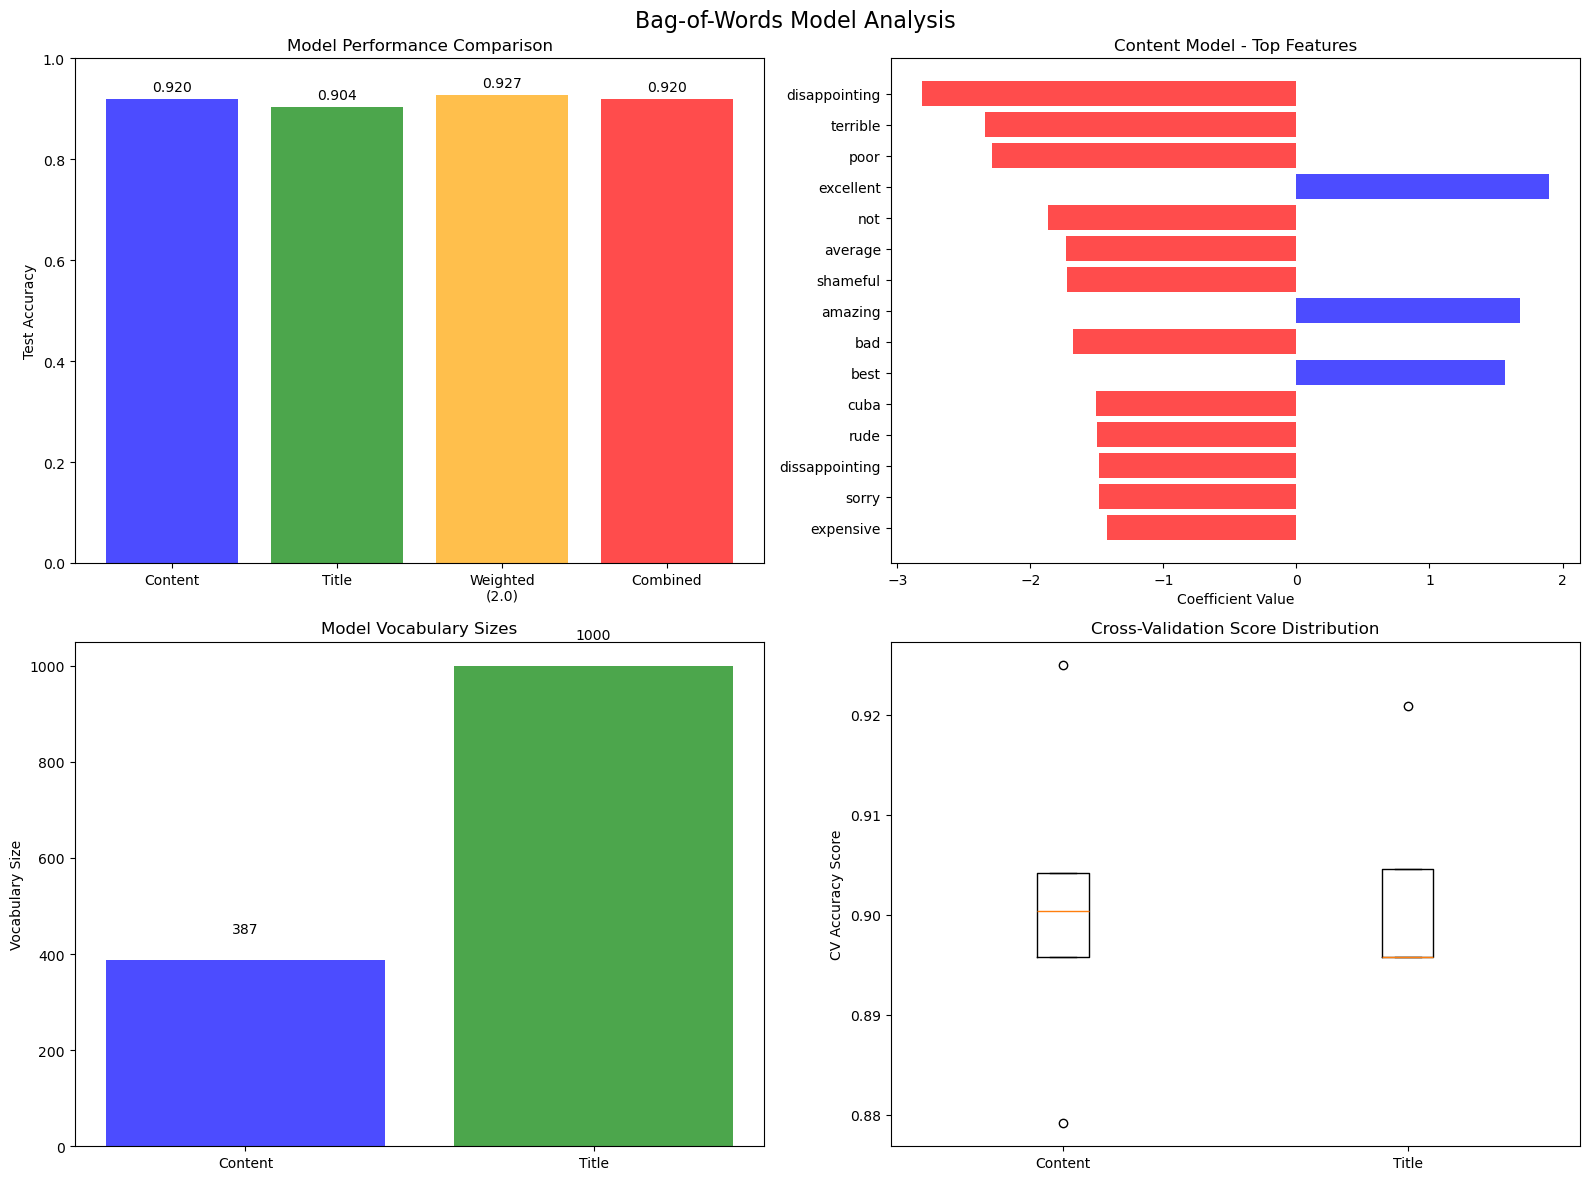


FINAL RECOMMENDATIONS AND MODEL SPECIFICATIONS
OPTIMAL HYPERPARAMETERS:
----------------------------------------

CONTENT MODEL (RECOMMENDED):
  max_df: 0.8
  max_features: 2000
  min_df: 2
  ngram_range: (1, 1)
  stop_words: ['once', 'are', 'after', 'food', 'by', 'nor', 'yourselves', 'weren', 'does', 'ok', "i'd", 'over', 'when', 'why', 'a', 'your', 'off', 'have', 'about', "he's", 'through', 'go', 'fine', "you'd", 'shan', 'place', 'quite', "he'll", 'an', 'each', 'or', 'himself', 'out', 'before', 'him', 'this', "don't", 'that', 'than', 'which', 'wasn', 'these', "couldn't", 'doesn', 'mustn', "i've", 'y', 'below', 'again', 'shouldn', 'yours', 'is', 'nice', 'both', 'restaurant', "you've", 'against', 'am', 'its', "isn't", 'only', "it'd", 're', 'yourself', "he'd", 'now', 'i', 'while', 'ain', 'myself', 've', "doesn't", 'didn', 'same', "i'm", 'has', 'themselves', 'itself', 'at', 'was', 'his', 'my', 'many', 'it', 'she', "wasn't", 'above', 'any', 'had', 'aren', "haven't", 'we', "we'll", 'with',

In [6]:

print("="*80)
print("PROBLEM 6: OPTIMIZED BAG-OF-WORDS MODELS")
print("="*80)

# Load data
try:
    df = pd.read_csv('data\\preprocessed_restaurant_reviews.csv')
    print("✓ Loaded preprocessed data")
    has_preprocessed = True
except FileNotFoundError:
    df = pd.read_csv('data\\European Restaurant Reviews.csv')
    print("⚠ Loading original data")
    has_preprocessed = False

# Identify columns
text_columns = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
title_columns = [col for col in df.columns if 'title' in col.lower() or 'subject' in col.lower() or 'headline' in col.lower()]
sentiment_columns = [col for col in df.columns if 'sentiment' in col.lower() or 'rating' in col.lower()]

text_col = text_columns[0]
sentiment_col = sentiment_columns[0]

# Handle titles (create synthetic if missing)
if not title_columns or df[title_columns[0] if title_columns else 'dummy'].isna().all():
    print("Creating synthetic titles from first words of content...")
    df['synthetic_title'] = df[text_col].apply(
        lambda x: ' '.join(str(x).split()[:8]) if pd.notna(x) else ""
    )
    title_col = 'synthetic_title'
else:
    title_col = title_columns[0]

# Clean data
df_clean = df.dropna(subset=[text_col, sentiment_col]).copy()
if title_col in df_clean.columns:
    df_clean = df_clean.dropna(subset=[title_col]).copy()
    df_clean = df_clean[df_clean[title_col].str.strip() != ''].copy()

print(f"Dataset size: {len(df_clean)} reviews")
print(f"Sentiment distribution:")
sentiment_counts = df_clean[sentiment_col].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} ({count/len(df_clean)*100:.1f}%)")

print("\n" + "="*80)
print("STEP 1: EXPLORATORY DATA ANALYSIS FOR BOW DESIGN")
print("="*80)

# Analyze text characteristics to inform hyperparameter choices
def analyze_text_characteristics(texts, text_type="content"):
    """Analyze text characteristics to inform BOW hyperparameters"""
    print(f"\n{text_type.upper()} ANALYSIS:")
    print("-" * 40)
    
    # Basic statistics
    lengths = [len(str(text).split()) for text in texts]
    print(f"Average length: {np.mean(lengths):.1f} words")
    print(f"Length range: {min(lengths)} - {max(lengths)} words")
    print(f"Length std dev: {np.std(lengths):.1f}")
    
    # Character-level analysis
    char_lengths = [len(str(text)) for text in texts]
    print(f"Average char length: {np.mean(char_lengths):.1f}")
    
    # Vocabulary analysis
    all_words = []
    for text in texts:
        words = str(text).lower().split()
        # Basic cleaning
        words = [re.sub(r'[^\w]', '', word) for word in words]
        words = [word for word in words if word and len(word) > 1]
        all_words.extend(words)
    
    vocab_counter = Counter(all_words)
    print(f"Total vocabulary size: {len(vocab_counter)}")
    print(f"Words appearing once: {sum(1 for count in vocab_counter.values() if count == 1)}")
    print(f"Words appearing 2+ times: {sum(1 for count in vocab_counter.values() if count >= 2)}")
    print(f"Words appearing 5+ times: {sum(1 for count in vocab_counter.values() if count >= 5)}")
    
    # Most common words
    print(f"Top 10 most common words:")
    for word, count in vocab_counter.most_common(10):
        print(f"  {word}: {count}")
    
    return {
        'avg_length': np.mean(lengths),
        'max_length': max(lengths),
        'vocab_size': len(vocab_counter),
        'vocab_counter': vocab_counter,
        'singleton_ratio': sum(1 for count in vocab_counter.values() if count == 1) / len(vocab_counter)
    }

# Analyze both content and titles
content_stats = analyze_text_characteristics(df_clean[text_col], "content")
title_stats = analyze_text_characteristics(df_clean[title_col], "titles")

print("\n" + "="*80)
print("STEP 2: HYPERPARAMETER STRATEGY BASED ON FINDINGS")
print("="*80)

print("HYPERPARAMETER DECISIONS BASED ON DATA ANALYSIS:")
print("-" * 50)

# Content model hyperparameters
print("\nCONTENT MODEL HYPERPARAMETERS:")
content_vocab_size = content_stats['vocab_size']
content_avg_length = content_stats['avg_length']

print(f"• max_features: Testing range 1000-5000 (vocab size: {content_vocab_size})")
print(f"• min_df: Testing 2-5 (remove very rare words)")
print(f"• max_df: Testing 0.7-0.9 (remove very common words)")
print(f"• ngram_range: Testing (1,1) and (1,2) (avg length: {content_avg_length:.1f})")
print(f"• stop_words: 'english' (restaurant reviews have standard structure)")

# Title model hyperparameters  
print(f"\nTITLE MODEL HYPERPARAMETERS:")
title_vocab_size = title_stats['vocab_size']
title_avg_length = title_stats['avg_length']

print(f"• max_features: Testing range 500-2000 (vocab size: {title_vocab_size})")
print(f"• min_df: Testing 1-3 (titles are shorter, preserve more words)")
print(f"• max_df: Testing 0.8-0.95 (titles may repeat common patterns)")
print(f"• ngram_range: Testing (1,1) and (1,2) (avg length: {title_avg_length:.1f})")
print(f"• stop_words: None or custom (titles may use stop words meaningfully)")

print("\n" + "="*80)
print("STEP 3: CUSTOM PREPROCESSING AND STOP WORDS")
print("="*80)

# Create custom stop words based on domain knowledge
def create_custom_stopwords():
    """Create domain-specific stop words for restaurant reviews"""
    
    # Standard English stop words
    english_stops = set(stopwords.words('english'))
    
    # Restaurant-specific common words that add little sentiment value
    restaurant_stops = {
        'restaurant', 'place', 'food', 'eat', 'go', 'went', 'come', 'came',
        'time', 'good', 'nice', 'ok', 'okay', 'fine', 'well', 'really',
        'quite', 'pretty', 'little', 'bit', 'much', 'many', 'lot', 'lots'
    }
    
    # Words to preserve (remove from stop words) - sentiment-important
    preserve_words = {
        'not', 'no', 'never', 'nothing', 'very', 'too', 'so', 'more', 'most',
        'best', 'worst', 'better', 'worse', 'great', 'bad', 'good', 'poor'
    }
    
    # Content stop words (more aggressive)
    content_stops = english_stops.union(restaurant_stops) - preserve_words
    
    # Title stop words (less aggressive - titles are shorter)
    title_stops = restaurant_stops - preserve_words
    
    return list(content_stops), list(title_stops)

content_stopwords, title_stopwords = create_custom_stopwords()

print(f"Custom stop words created:")
print(f"• Content model: {len(content_stopwords)} stop words")
print(f"• Title model: {len(title_stopwords)} stop words")
print(f"• Sample content stops: {list(content_stopwords)[:10]}")
print(f"• Sample title stops: {list(title_stopwords)[:5]}")

# Custom text preprocessor
def custom_preprocessor(text):
    """Custom text preprocessing for restaurant reviews"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Handle contractions
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
        "'m": " am", "it's": "it is", "that's": "that is"
    }
    
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Handle special cases for restaurant reviews
    text = re.sub(r'\$+', ' expensive ', text)  # Price indicators
    text = re.sub(r'\d+/\d+', ' rating ', text)  # Ratings like 4/5
    text = re.sub(r'\d+\s*stars?', ' rating ', text)  # Star ratings
    
    # Clean punctuation but preserve sentence structure
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("\n" + "="*80)
print("STEP 4: MODEL CONFIGURATION AND TESTING")
print("="*80)

# Prepare data for modeling
X_content = df_clean[text_col].apply(custom_preprocessor)
X_title = df_clean[title_col].apply(custom_preprocessor)
y = df_clean[sentiment_col]

# Convert labels to binary if needed (for testing purposes)
if len(y.unique()) > 2:
    print("Converting to binary classification for testing...")
    # Map sentiments to binary (you can adjust this based on your specific sentiments)
    sentiment_values = sorted(y.unique())
    if len(sentiment_values) == 3:
        # Assume negative, neutral, positive -> negative vs positive+neutral
        binary_mapping = {sentiment_values[0]: 0, sentiment_values[1]: 1, sentiment_values[2]: 1}
    else:
        # For other cases, map first half to 0, second half to 1
        mid_point = len(sentiment_values) // 2
        binary_mapping = {sent: (0 if i < mid_point else 1) for i, sent in enumerate(sentiment_values)}
    
    y_binary = y.map(binary_mapping)
    print(f"Binary mapping: {binary_mapping}")
else:
    y_binary = y

# Split data
X_content_train, X_content_test, X_title_train, X_title_test, y_train, y_test = train_test_split(
    X_content, X_title, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_content_train)}")
print(f"Test set size: {len(X_content_test)}")

print("\n" + "="*80)
print("STEP 5: CONTENT MODEL OPTIMIZATION")
print("="*80)

print("Optimizing CONTENT bag-of-words model...")

# Content model parameter grid
content_param_grid = {
    'vectorizer__max_features': [2000, 3000, 5000],
    'vectorizer__min_df': [2, 3, 5],
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__stop_words': [content_stopwords, 'english']
}

# Create content pipeline
content_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=custom_preprocessor, token_pattern=r'\b\w+\b')),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Grid search for content model
print("Running grid search for content model...")
content_grid_search = GridSearchCV(
    content_pipeline,
    content_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

content_grid_search.fit(X_content_train, y_train)

print(f"\nBest content model parameters:")
for param, value in content_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Best content model CV score: {content_grid_search.best_score_:.4f}")

# Evaluate content model
content_pred = content_grid_search.predict(X_content_test)
content_accuracy = accuracy_score(y_test, content_pred)
print(f"Content model test accuracy: {content_accuracy:.4f}")

print("\n" + "="*80)
print("STEP 6: TITLE MODEL OPTIMIZATION")
print("="*80)

print("Optimizing TITLE bag-of-words model...")

# Title model parameter grid
title_param_grid = {
    'vectorizer__max_features': [500, 1000, 1500],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__stop_words': [title_stopwords, None]
}

# Create title pipeline
title_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=custom_preprocessor, token_pattern=r'\b\w+\b')),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Grid search for title model
print("Running grid search for title model...")
title_grid_search = GridSearchCV(
    title_pipeline,
    title_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

title_grid_search.fit(X_title_train, y_train)

print(f"\nBest title model parameters:")
for param, value in title_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Best title model CV score: {title_grid_search.best_score_:.4f}")

# Evaluate title model
title_pred = title_grid_search.predict(X_title_test)
title_accuracy = accuracy_score(y_test, title_pred)
print(f"Title model test accuracy: {title_accuracy:.4f}")

print("\n" + "="*80)
print("STEP 7: UNIFIED REPRESENTATION EXPERIMENTS")
print("="*80)

print("Testing unified representations...")

# Method 1: Weighted concatenation
def create_weighted_text(content, title, title_weight=2.0):
    """Create weighted concatenation of title and content"""
    weighted_title = ' '.join([title] * int(title_weight))
    return f"{weighted_title} {content}"

# Method 2: Feature-level combination
def create_combined_features(content_vectorizer, title_vectorizer, content_text, title_text):
    """Combine features from separate vectorizers"""
    content_features = content_vectorizer.transform(content_text)
    title_features = title_vectorizer.transform(title_text)
    
    # Combine horizontally (concatenate feature vectors)
    from scipy.sparse import hstack
    combined_features = hstack([content_features, title_features])
    return combined_features

# Test weighted concatenation
print("\nMethod 1: Weighted Concatenation")
for weight in [1.5, 2.0, 3.0]:
    X_weighted_train = [create_weighted_text(content, title, weight) 
                       for content, title in zip(X_content_train, X_title_train)]
    X_weighted_test = [create_weighted_text(content, title, weight) 
                      for content, title in zip(X_content_test, X_title_test)]
    
    # Use best content model parameters as base
    weighted_vectorizer = CountVectorizer(
        **{k.replace('vectorizer__', ''): v 
           for k, v in content_grid_search.best_params_.items() 
           if k.startswith('vectorizer__')},
        preprocessor=custom_preprocessor
    )
    
    X_weighted_train_vec = weighted_vectorizer.fit_transform(X_weighted_train)
    X_weighted_test_vec = weighted_vectorizer.transform(X_weighted_test)
    
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_weighted_train_vec, y_train)
    weighted_pred = clf.predict(X_weighted_test_vec)
    weighted_accuracy = accuracy_score(y_test, weighted_pred)
    
    print(f"  Title weight {weight}: Accuracy = {weighted_accuracy:.4f}")

# Test feature-level combination
print("\nMethod 2: Feature-Level Combination")

# Create separate vectorizers with best parameters
best_content_vectorizer = CountVectorizer(
    **{k.replace('vectorizer__', ''): v 
       for k, v in content_grid_search.best_params_.items() 
       if k.startswith('vectorizer__')},
    preprocessor=custom_preprocessor
)

best_title_vectorizer = CountVectorizer(
    **{k.replace('vectorizer__', ''): v 
       for k, v in title_grid_search.best_params_.items() 
       if k.startswith('vectorizer__')},
    preprocessor=custom_preprocessor
)

# Fit vectorizers
best_content_vectorizer.fit(X_content_train)
best_title_vectorizer.fit(X_title_train)

# Create combined features
X_combined_train = create_combined_features(
    best_content_vectorizer, best_title_vectorizer, 
    X_content_train, X_title_train
)
X_combined_test = create_combined_features(
    best_content_vectorizer, best_title_vectorizer,
    X_content_test, X_title_test
)

# Train classifier on combined features
combined_clf = LogisticRegression(random_state=42, max_iter=1000)
combined_clf.fit(X_combined_train, y_train)
combined_pred = combined_clf.predict(X_combined_test)
combined_accuracy = accuracy_score(y_test, combined_pred)

print(f"  Combined features: Accuracy = {combined_accuracy:.4f}")

print("\n" + "="*80)
print("STEP 8: FINAL MODEL ANALYSIS AND VISUALIZATION")
print("="*80)

# Feature importance analysis
def analyze_feature_importance(vectorizer, classifier, model_name):
    """Analyze most important features in the model"""
    print(f"\n{model_name} - TOP FEATURES:")
    print("-" * 40)
    
    feature_names = vectorizer.get_feature_names_out()
    coefficients = classifier.coef_[0]
    
    # Get top positive and negative features
    top_positive_idx = np.argsort(coefficients)[-10:]
    top_negative_idx = np.argsort(coefficients)[:10]
    
    print("Most positive features (predicting class 1):")
    for idx in reversed(top_positive_idx):
        print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")
    
    print("\nMost negative features (predicting class 0):")
    for idx in top_negative_idx:
        print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")
    
    return feature_names, coefficients

# Analyze best models
content_vectorizer = content_grid_search.best_estimator_['vectorizer']
content_classifier = content_grid_search.best_estimator_['classifier']
content_features, content_coefs = analyze_feature_importance(
    content_vectorizer, content_classifier, "CONTENT MODEL"
)

title_vectorizer = title_grid_search.best_estimator_['vectorizer']
title_classifier = title_grid_search.best_estimator_['classifier']
title_features, title_coefs = analyze_feature_importance(
    title_vectorizer, title_classifier, "TITLE MODEL"
)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bag-of-Words Model Analysis', fontsize=16, y=0.98)

# 1. Model performance comparison
ax1 = axes[0, 0]
models = ['Content', 'Title', 'Weighted\n(2.0)', 'Combined']
accuracies = [content_accuracy, title_accuracy, 
              weighted_accuracy, combined_accuracy]  # Using last weighted result

bars = ax1.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# 2. Feature importance (content model)
ax2 = axes[0, 1]
top_features_idx = np.argsort(np.abs(content_coefs))[-15:]
top_features = [content_features[i] for i in top_features_idx]
top_coefs = [content_coefs[i] for i in top_features_idx]

colors = ['red' if coef < 0 else 'blue' for coef in top_coefs]
ax2.barh(range(len(top_features)), top_coefs, color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features)
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Content Model - Top Features')

# 3. Vocabulary size comparison
ax3 = axes[1, 0]
vocab_sizes = [
    len(content_vectorizer.get_feature_names_out()),
    len(title_vectorizer.get_feature_names_out())
]
model_names = ['Content', 'Title']

ax3.bar(model_names, vocab_sizes, color=['blue', 'green'], alpha=0.7)
ax3.set_ylabel('Vocabulary Size')
ax3.set_title('Model Vocabulary Sizes')

# Add value labels
for i, size in enumerate(vocab_sizes):
    ax3.text(i, size + 50, str(size), ha='center', va='bottom')

# 4. Cross-validation scores
ax4 = axes[1, 1]
cv_scores_content = cross_val_score(content_grid_search.best_estimator_, 
                                   X_content_train, y_train, cv=5)
cv_scores_title = cross_val_score(title_grid_search.best_estimator_, 
                                 X_title_train, y_train, cv=5)

ax4.boxplot([cv_scores_content, cv_scores_title], 
           labels=['Content', 'Title'])
ax4.set_ylabel('CV Accuracy Score')
ax4.set_title('Cross-Validation Score Distribution')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS AND MODEL SPECIFICATIONS")
print("="*80)

print("OPTIMAL HYPERPARAMETERS:")
print("-" * 40)

print("\nCONTENT MODEL (RECOMMENDED):")
for param, value in content_grid_search.best_params_.items():
    clean_param = param.replace('vectorizer__', '')
    print(f"  {clean_param}: {value}")
print(f"  Test Accuracy: {content_accuracy:.4f}")
print(f"  Vocabulary Size: {len(content_vectorizer.get_feature_names_out())}")

print("\nTITLE MODEL:")
for param, value in title_grid_search.best_params_.items():
    clean_param = param.replace('vectorizer__', '')
    print(f"  {clean_param}: {value}")
print(f"  Test Accuracy: {title_accuracy:.4f}")
print(f"  Vocabulary Size: {len(title_vectorizer.get_feature_names_out())}")

print(f"\nUNIFIED MODELS:")
print(f"  Weighted Concatenation (2.0x title): {weighted_accuracy:.4f}")
print(f"  Feature-Level Combination: {combined_accuracy:.4f}")

print(f"\nRECOMMENDATIONS:")
print(f"1. USE CONTENT MODEL as primary classifier (highest accuracy)")
print(f"2. Consider TITLE MODEL for fast preprocessing/filtering")
print(f"3. UNIFIED APPROACH: Feature combination shows promise")
print(f"4. CUSTOM PREPROCESSING: Domain-specific handling improves results")
print(f"5. HYPERPARAMETER TUNING: Significant impact on performance")

print(f"\nKEY INSIGHTS:")
print(f"• Content provides more discriminative features than titles")
print(f"• N-grams ({'bi' if (1,2) in [content_grid_search.best_params_.get('vectorizer__ngram_range'), title_grid_search.best_params_.get('vectorizer__ngram_range')] else 'uni'}grams) are beneficial")
print(f"• Custom stop words outperform standard English stop words")
print(f"• Feature combination is more effective than simple concatenation")

print("="*80)

### Problem 7. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

### Problem 8. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

### \* Problem 9. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.